<a href="https://colab.research.google.com/github/sktlim/PairsTradingExploration/blob/main/DSAI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Problem: How can we leverage machine learning techniques and other stock indicators to replace the Rolling Z-Score in pairs trading, while ensuring consistent profitability?

Pairs Trading is a strategy that is pioneered in the 1980s as a market neutral strategy involving the trading of highly correlated stocks. While the premise of this strategy and its typical implementation using rolling Z-score still holds today, this strategy is liable to errors such as a correlation breakdown which could result in losses for the trader.

In this notebook, we explore other forms of implementing Pairs Trading using Machine Learning techniques. We then measure their profitability and classification accuracy to view their efficacy against the original implementation using Z-score.

# Essential Libraries

First, we import the libraries that require to investigate our pairs trading implementation.

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
import missingno
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
import yfinance as yf
import seaborn as sn
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
import pandas_ta as ta
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import requests

We define a custom function to extract the historical data of specified tickers from 1 Dec 2020 to 1 Jan 2022 for the first part of our Exploratory Data Analysis.


In [ ]:
def get_historical_Data(tickers):
    """This function returns a pd dataframe with all of the adjusted closing information"""
    data = pd.DataFrame()
    names = list()
    for i in tickers:
        data = pd.concat([data, pd.DataFrame(yf.download(i, start=datetime(2020, 12, 1), end=datetime(2022, 1, 1)).iloc[:,4])], axis = 1)
        names.append(i)
    data.columns = names
    return data

# Exploratory Data Analysis 
Now, we are ready to begin our Exploratory Data Analysis to find cointegrated pairs of stocks to conduct our pairs trading strategy upon. First, let's scrape the S&P 500 symbols list so that we can use our get_historical_data function to extract its stock data.

In [ ]:
# Scrape S&P 500 Symbol list

url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

header = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
    "X-Requested-With": "XMLHttpRequest"
}

page = requests.get(url, headers=header)

dfs = pd.read_html(page.text)

snp500_df = dfs[0]
snp500_df.head()

Symbol     Security             GICS Sector               GICS Sub-Industry  \
0    MMM           3M             Industrials        Industrial Conglomerates   
1    AOS  A. O. Smith             Industrials               Building Products   
2    ABT       Abbott             Health Care           Health Care Equipment   
3   ABBV       AbbVie             Health Care                 Pharmaceuticals   
4    ACN    Accenture  Information Technology  IT Consulting & Other Services   

     Headquarters Location  Date added      CIK      Founded  
0    Saint Paul, Minnesota  1957-03-04    66740         1902  
1     Milwaukee, Wisconsin  2017-07-26    91142         1916  
2  North Chicago, Illinois  1957-03-04     1800         1888  
3  North Chicago, Illinois  2012-12-31  1551152  2013 (1888)  
4          Dublin, Ireland  2011-07-06  1467373         1989

Next, we extract the historical data for these symbols.


In [ ]:
# Get historical data for S&P500 from Jan 2021 - Jan 2022
snp500_symbol_list = snp500_df['Symbol'].to_list()
stock_data_original_df = get_historical_Data(snp500_symbol_list)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AES: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*****************

Now that we have the relevant stock data, let's make a deep copy of the dataframe for our initial data cleaning.

In [ ]:
stock_data_original_df.head()

stock_data_df = stock_data_original_df.copy(deep=True)

First, we visualize the dataset that we got from yahoo finance using the missingno library and remove the columns with more than 20% missing data.

<Axes: >

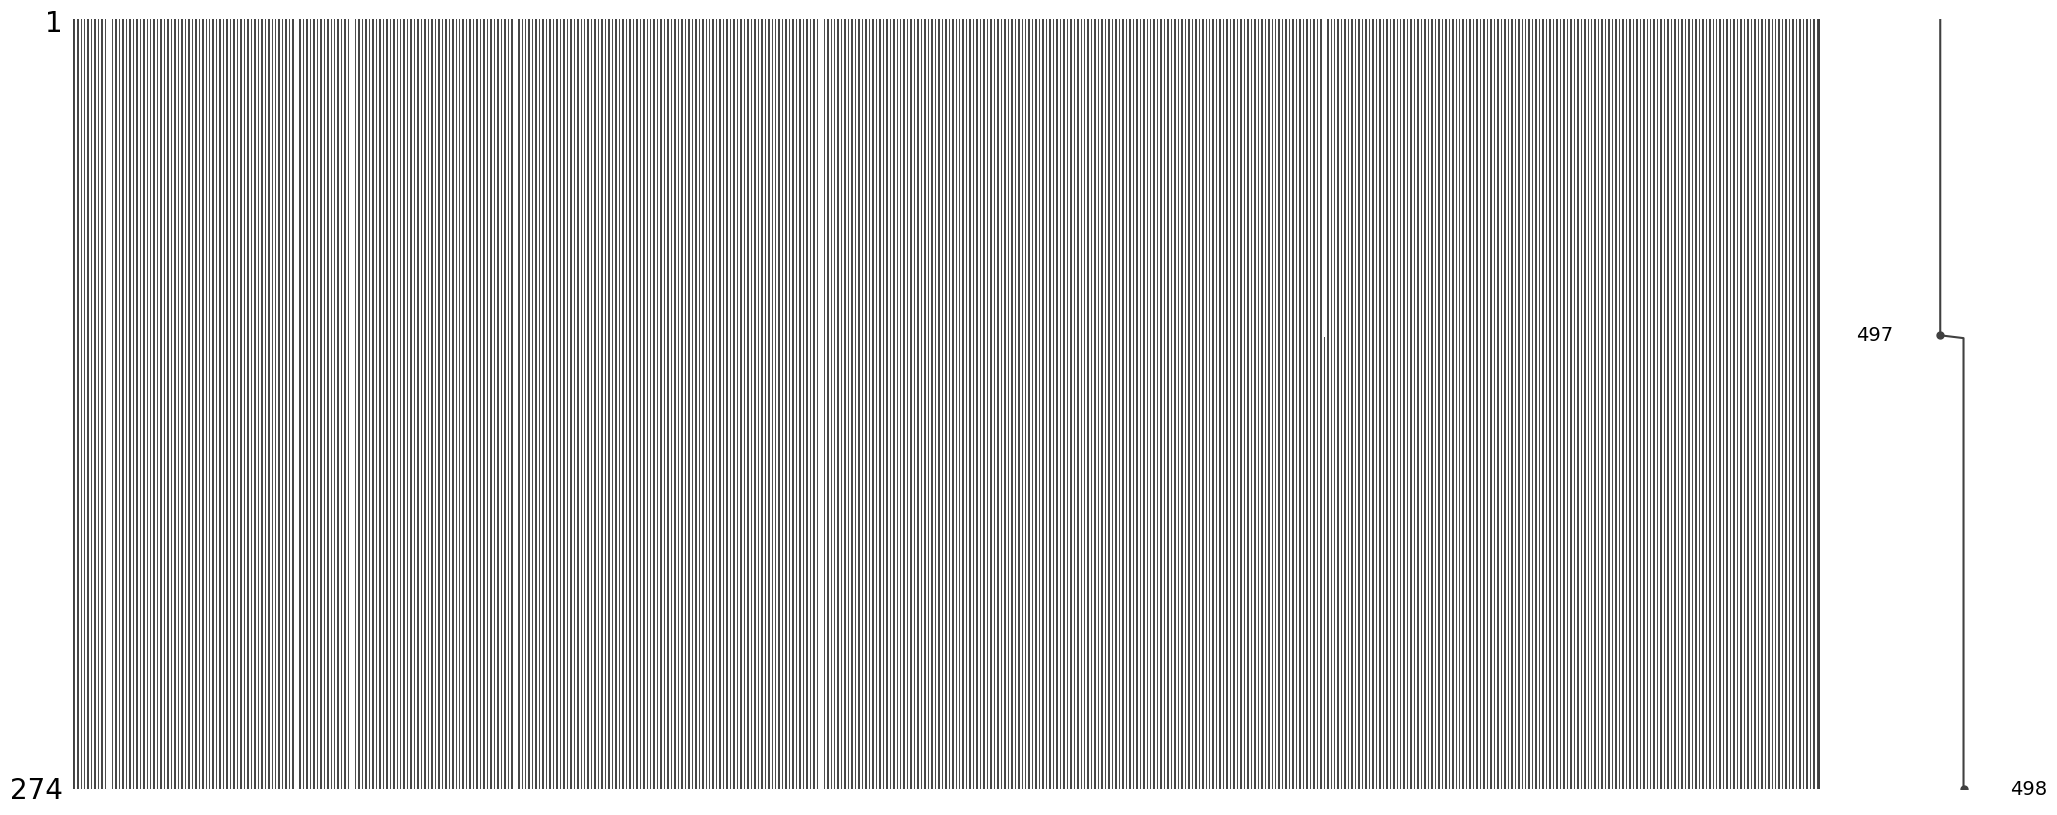

In [ ]:
missingno.matrix(stock_data_df)

<Axes: >

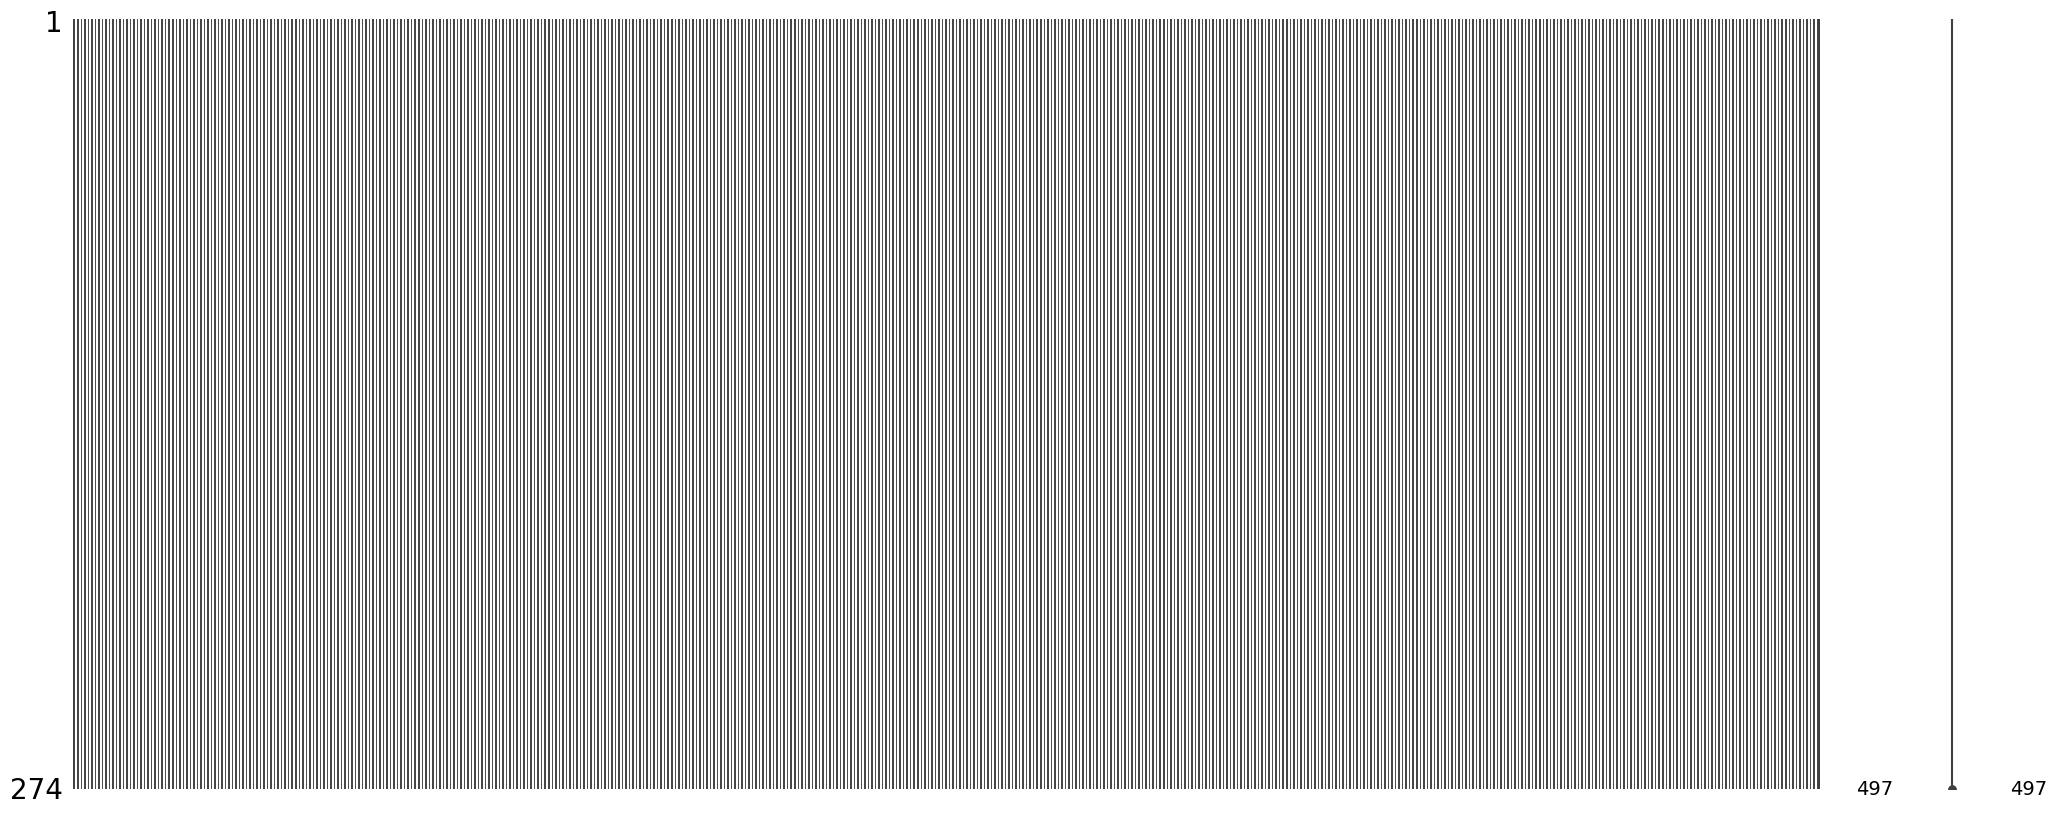

In [ ]:
#Clean historical data, Data preparation

missing_percentage = stock_data_df.isnull().mean().sort_values(ascending=False)
missing_percentage.head(10)
dropped_list = sorted(list(missing_percentage[missing_percentage > 0.2].index))
stock_data_df.drop(labels=dropped_list, axis=1, inplace=True)
stock_data_df = stock_data_df.fillna(method='ffill')

stock_data_df.shape

missingno.matrix(stock_data_df)

Now that our data is clean, we will go on to find cointegrated pairs. For our clustering task, we are interested in the volatility and performance of stocks and thus we want to obtain the variance and returns on an annual level.

In [ ]:
#Calculate returns and create a data frame
returns = stock_data_df.pct_change().mean()*266
returns = pd.DataFrame(returns)
returns.columns = ['returns']

#Calculate the volatility
returns['volatility'] = stock_data_df.pct_change().std()*np.sqrt(266)

stock_data_df = returns
stock_data_df.head()

returns  volatility
MMM   0.087555    0.186308
AOS   0.488580    0.281236
ABT   0.291058    0.210879
ABBV  0.323816    0.205897
ACN   0.518233    0.210430

We then scale the data using the StandardScaler from sklearn to reduce noise in our model.

In [ ]:
#Prepare the scaler
scale = StandardScaler().fit(stock_data_df)

#Fit the scaler
scaled_stock_data = pd.DataFrame(scale.fit_transform(stock_data_df),columns = stock_data_df.columns, index = stock_data_df.index)
scaled_stock_data.head()

returns  volatility
MMM  -0.979249   -1.052418
AOS   0.774942   -0.020402
ABT  -0.089070   -0.785293
ABBV  0.054221   -0.839461
ACN   0.904653   -0.790177

# Identification of Cointegrated pairs through K-means Clustering 

K-means clustering can now be applied to identify groups of stocks with their nearest mean.

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

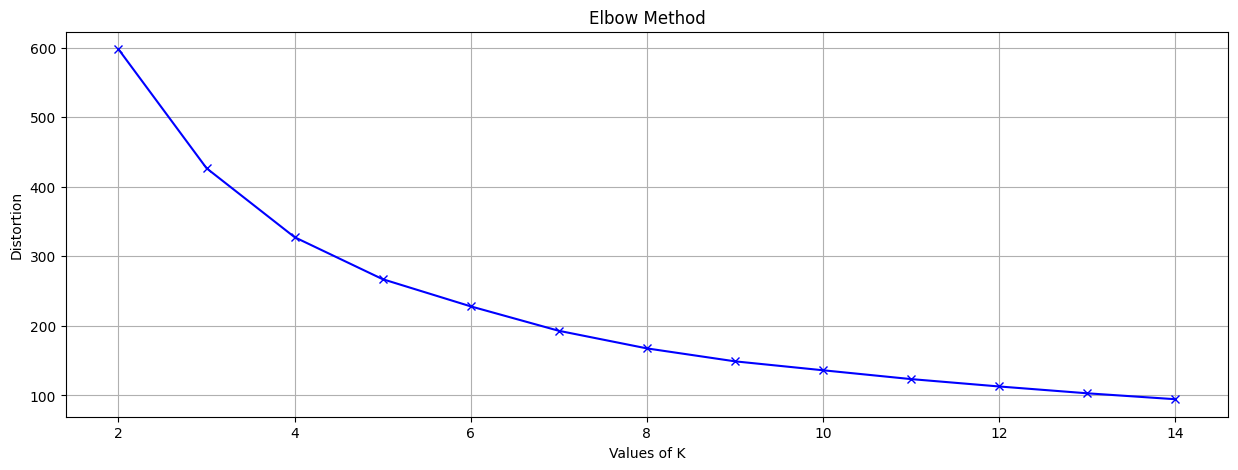

In [ ]:
# Find best number of clusters using elbow method
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt

K = range(2,15)
distortions = []

#Fit the method
for k in K:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(scaled_stock_data)
    distortions.append(kmeans.inertia_)

#Plot the results
fig = plt.figure(figsize= (15,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

Using the elbow method, we have identified that the optimal number of clusters that we should have is around 6 as beyond that, our clusters become less informative. Let's now visualize the K-means cluster results.

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


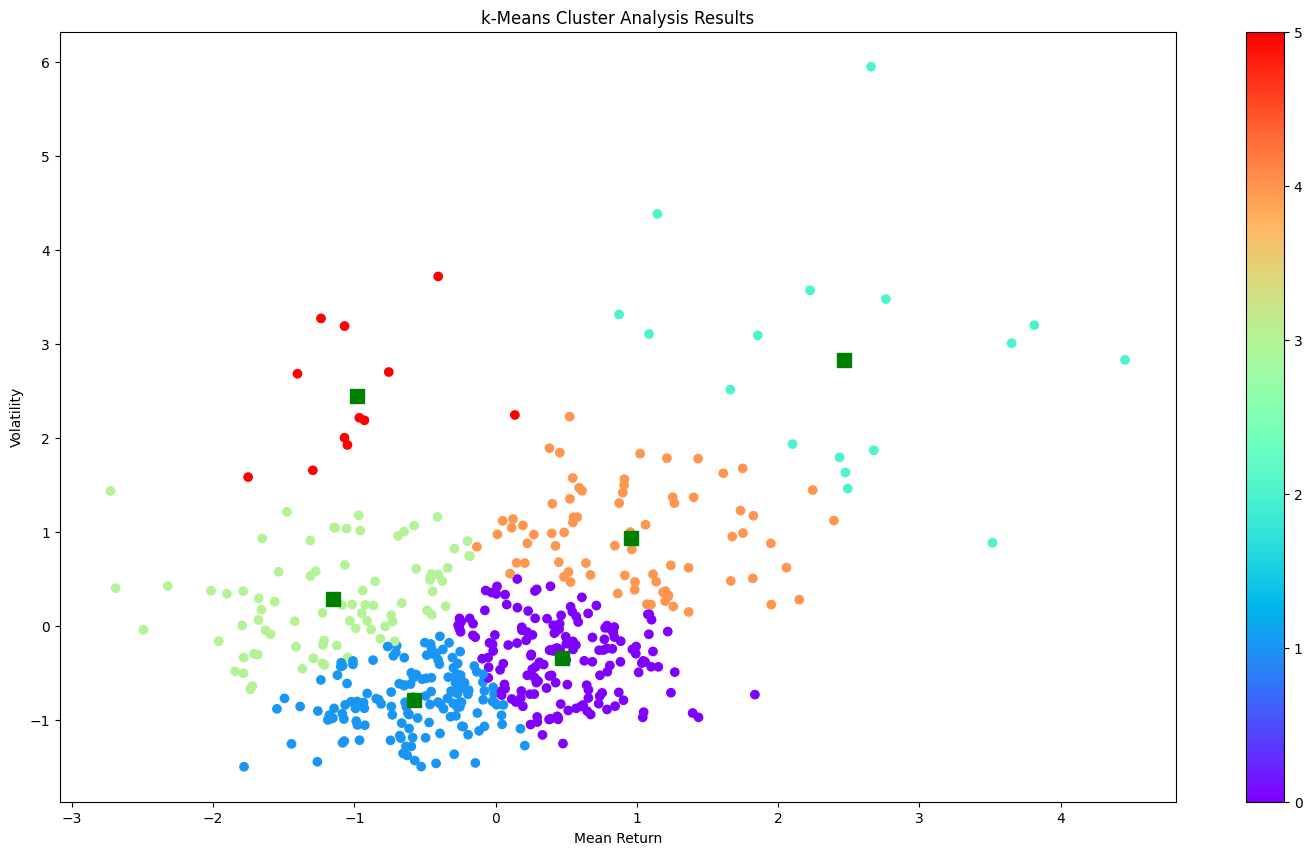

In [ ]:
# TODO: K-means clustering
c = 6
#Fit the model
k_means = KMeans(n_clusters=c)
k_means.fit(scaled_stock_data)
prediction = k_means.predict(scaled_stock_data)

#Plot the results
centroids = k_means.cluster_centers_
fig = plt.figure(figsize = (18,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(scaled_stock_data.iloc[:,0],scaled_stock_data.iloc[:,1], c=k_means.labels_, cmap="rainbow", label = scaled_stock_data.index)
ax.set_title('k-Means Cluster Analysis Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=10)
plt.show()

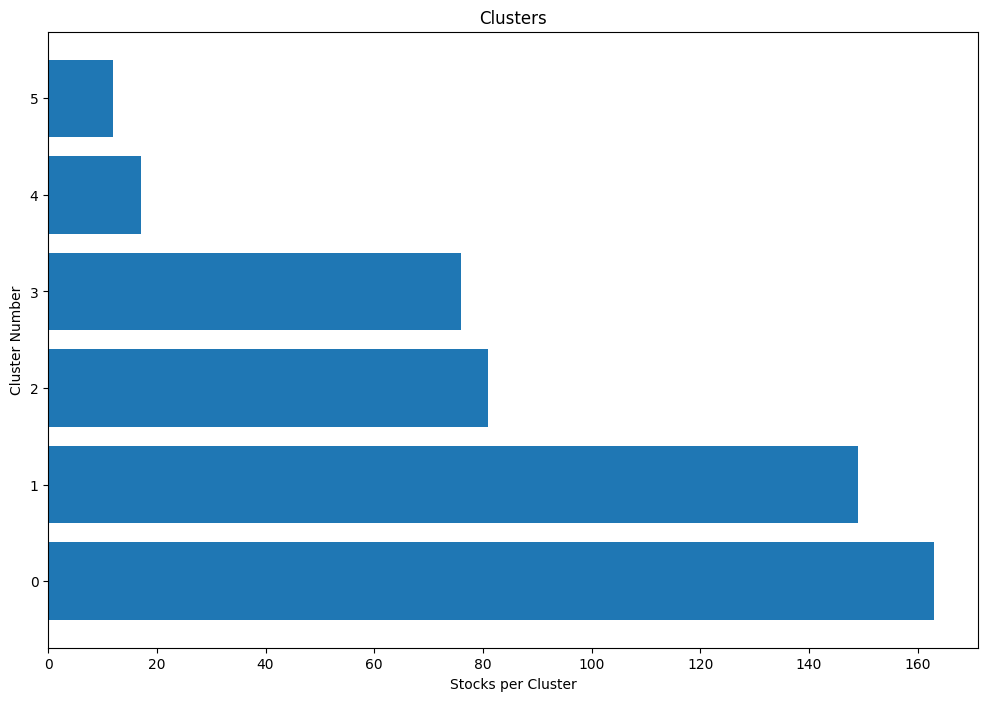

In [ ]:
# See how many stocks per cluster

clustered_series = pd.Series(index=scaled_stock_data.index, data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=scaled_stock_data.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
plt.figure(figsize=(12,8))
plt.barh(range(len(clustered_series.value_counts())),clustered_series.value_counts())
plt.title('Clusters')
plt.xlabel('Stocks per Cluster')
plt.ylabel('Cluster Number')
plt.show()

Now, let's analyse each cluster and look for the cointegrated pairs within them.

In [ ]:
cluster_size_limit = 1000
counts = clustered_series.value_counts()
ticker_count = counts[(counts>1) & (counts<=cluster_size_limit)]
print ("Number of clusters: %d" % len(ticker_count))
print ("Number of Pairs: %d" % (ticker_count*(ticker_count-1)).sum())

Number of clusters: 6
Number of Pairs: 61042


In [ ]:
from statsmodels.tsa.stattools import coint

def find_cointegrated_pairs(data, significance=0.05):
    n = data.shape[1]    
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(1):
        for j in range(i+1, n):
            S1 = data[keys[i]]            
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [ ]:
cluster_dict = {}

for i, clust in enumerate(ticker_count.index):
    tickers = clustered_series[clustered_series == clust].index
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(stock_data_original_df[tickers])
    cluster_dict[clust] = {}
    cluster_dict[clust]['score_matrix'] = score_matrix
    cluster_dict[clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[clust]['pairs'] = pairs
    
pairs = []   
for cluster in cluster_dict.keys():
    pairs.extend(cluster_dict[cluster]['pairs'])
    
print ("Number of pairs:", len(pairs))
print ("In those pairs, we found %d unique tickers." % len(np.unique(pairs)))
print(pairs)


Number of pairs: 14
In those pairs, we found 19 unique tickers.
[('AOS', 'MLM'), ('AOS', 'VMC'), ('MMM', 'LMT'), ('MMM', 'SWK'), ('ATVI', 'FIS'), ('ATVI', 'GPN'), ('ATVI', 'TFX'), ('ATVI', 'ZBH'), ('ALB', 'DXCM'), ('ALB', 'MPWR'), ('AAL', 'FSLR'), ('AAL', 'RCL'), ('AAL', 'SEDG'), ('AAL', 'UAL')]


Now that we found some pairs that we are interested in, let's visualize them using TSNE(t-distributed stochastic neighbor embedding). 

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm

stocks = np.unique(pairs)
X_data = pd.DataFrame(index=scaled_stock_data.index, data=scaled_stock_data).T
in_pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs))
X_pairs = X_data.T.loc[stocks]
X_pairs.head()

returns  volatility
AAL   0.135940    2.243716
ALB   1.433141    1.779384
AOS   0.774942   -0.020402
ATVI -1.903487    0.342477
DXCM  1.060822    1.076206

In [ ]:
X_tsne = TSNE(learning_rate=30, perplexity=5, random_state=42, n_jobs=-1).fit_transform(X_pairs)
X_tsne

array([[-26.382751 ,  46.20609  ],
       [-12.047968 ,  38.234367 ],
       [ -3.7975533,  20.527956 ],
       [ 29.420137 , -38.72574  ],
       [-10.661429 ,  30.17051  ],
       [ 22.94096  , -45.042713 ],
       [-38.476223 ,  47.5346   ],
       [ 29.819761 , -47.57795  ],
       [  9.036334 , -29.77532  ],
       [-10.450243 ,  18.430683 ],
       [  7.7827544, -22.941656 ],
       [-16.869547 ,  32.47491  ],
       [-32.585617 ,  51.07364  ],
       [-26.375233 ,  58.12105  ],
       [ 15.375386 , -25.315573 ],
       [ 23.927797 , -34.64689  ],
       [-38.711796 ,  54.342773 ],
       [ -5.08892  ,  13.543634 ],
       [ 17.527096 , -36.29386  ]], dtype=float32)

<ipython-input-44-dd2fcd3eec51>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='b');


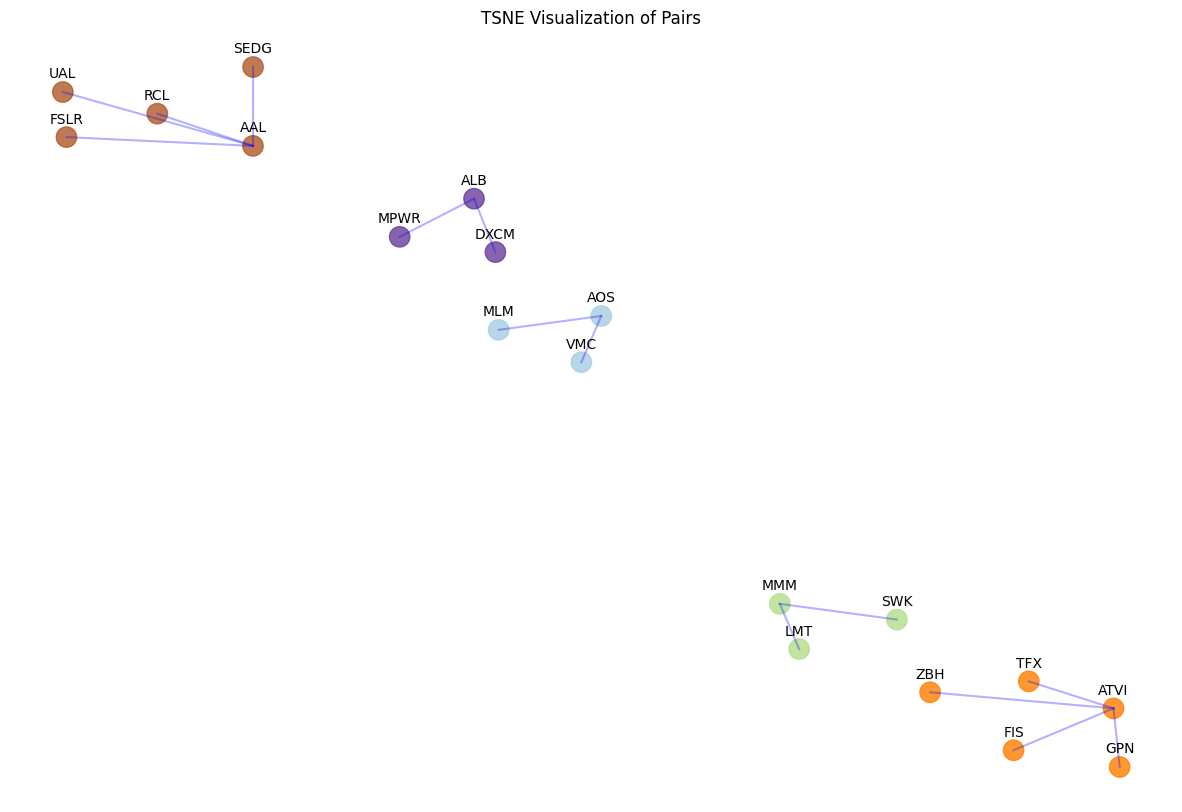

In [ ]:
plt.figure(1, facecolor='white',figsize=(15,10))
plt.clf()
plt.axis('off')
for pair in pairs:
    ticker1 = pair[0]
    loc1 = X_pairs.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]
    ticker2 = pair[0]
    loc2 = X_pairs.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='b');
    
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=215, alpha=0.8, c=in_pairs_series.values, cmap=cm.Paired)
plt.title('TSNE Visualization of Pairs'); 

# Join pairs by x and y
for x,y,name in zip(X_tsne[:,0],X_tsne[:,1],X_pairs.index):

    label = name

    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')
    
plt.show()

# Data Preparation and Exploratory Analysis of Target Pair (SWK and MMM)

Let's zoom in on the MMM and SWK pair for this part of the analysis. Note that we could technically also use any other cointegrated pair identified in our TSNE above and the results we obtain should still be similar.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


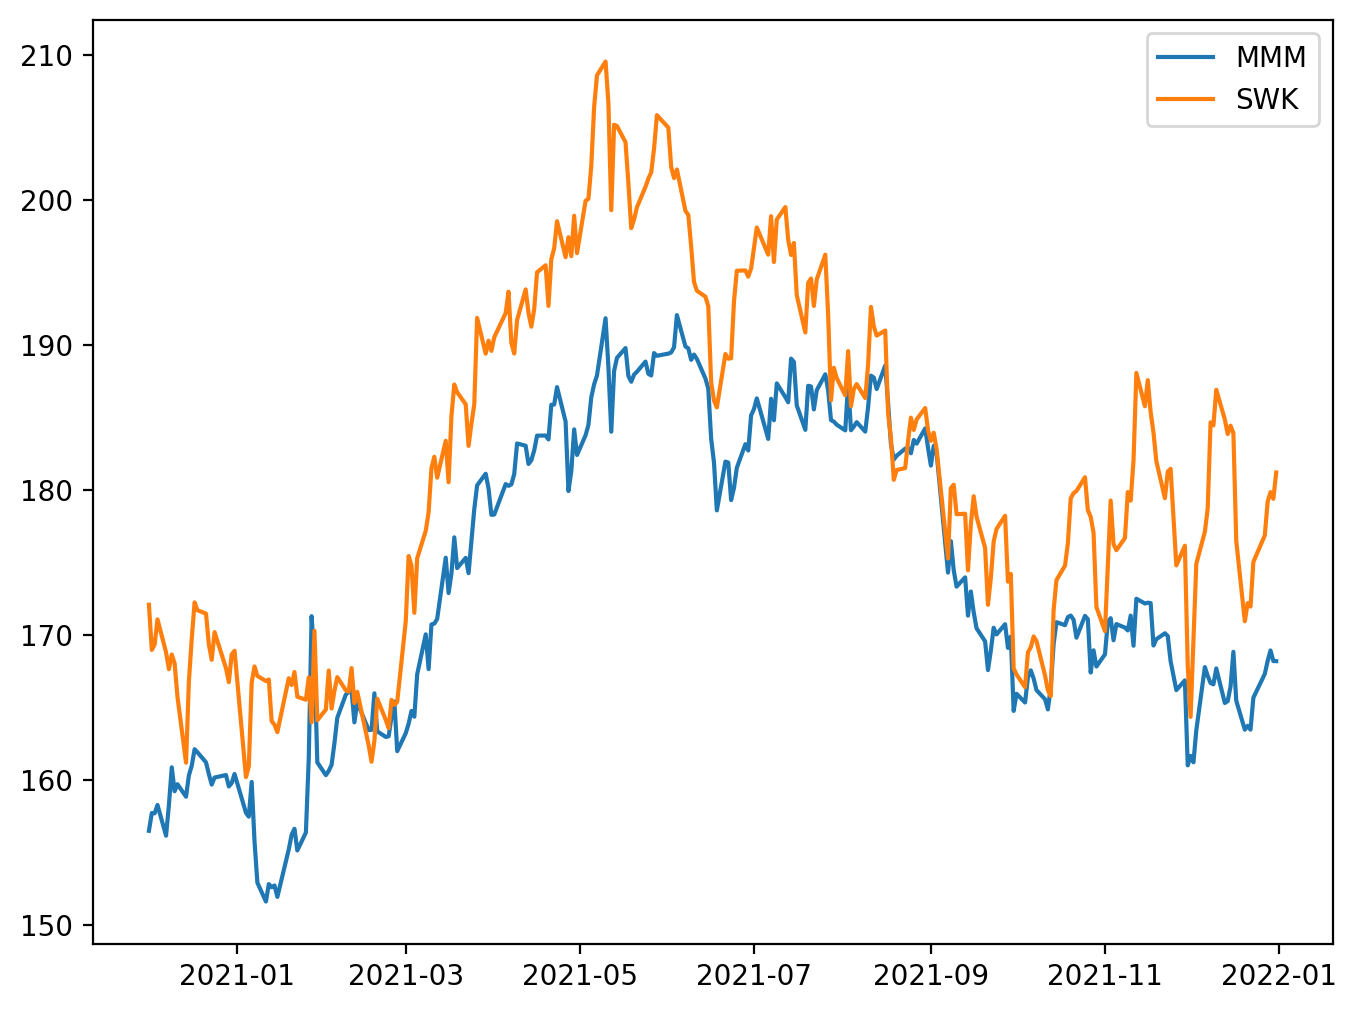

In [ ]:
d_year = get_historical_Data(['MMM', 'SWK'])
figure(figsize=(8, 6), dpi=200)
MMM = d_year['MMM'] # S&P 500
SWK = d_year['SWK'] # Microsoft
plt.plot(MMM, label = "MMM")
plt.plot(SWK, label = "SWK")
plt.legend()

Lets now take a look at the two stock prices from a different point of view. Using a boxplot, histogram, and violin plot gives us a better meausre of the data that we are dealing with

<Axes: >

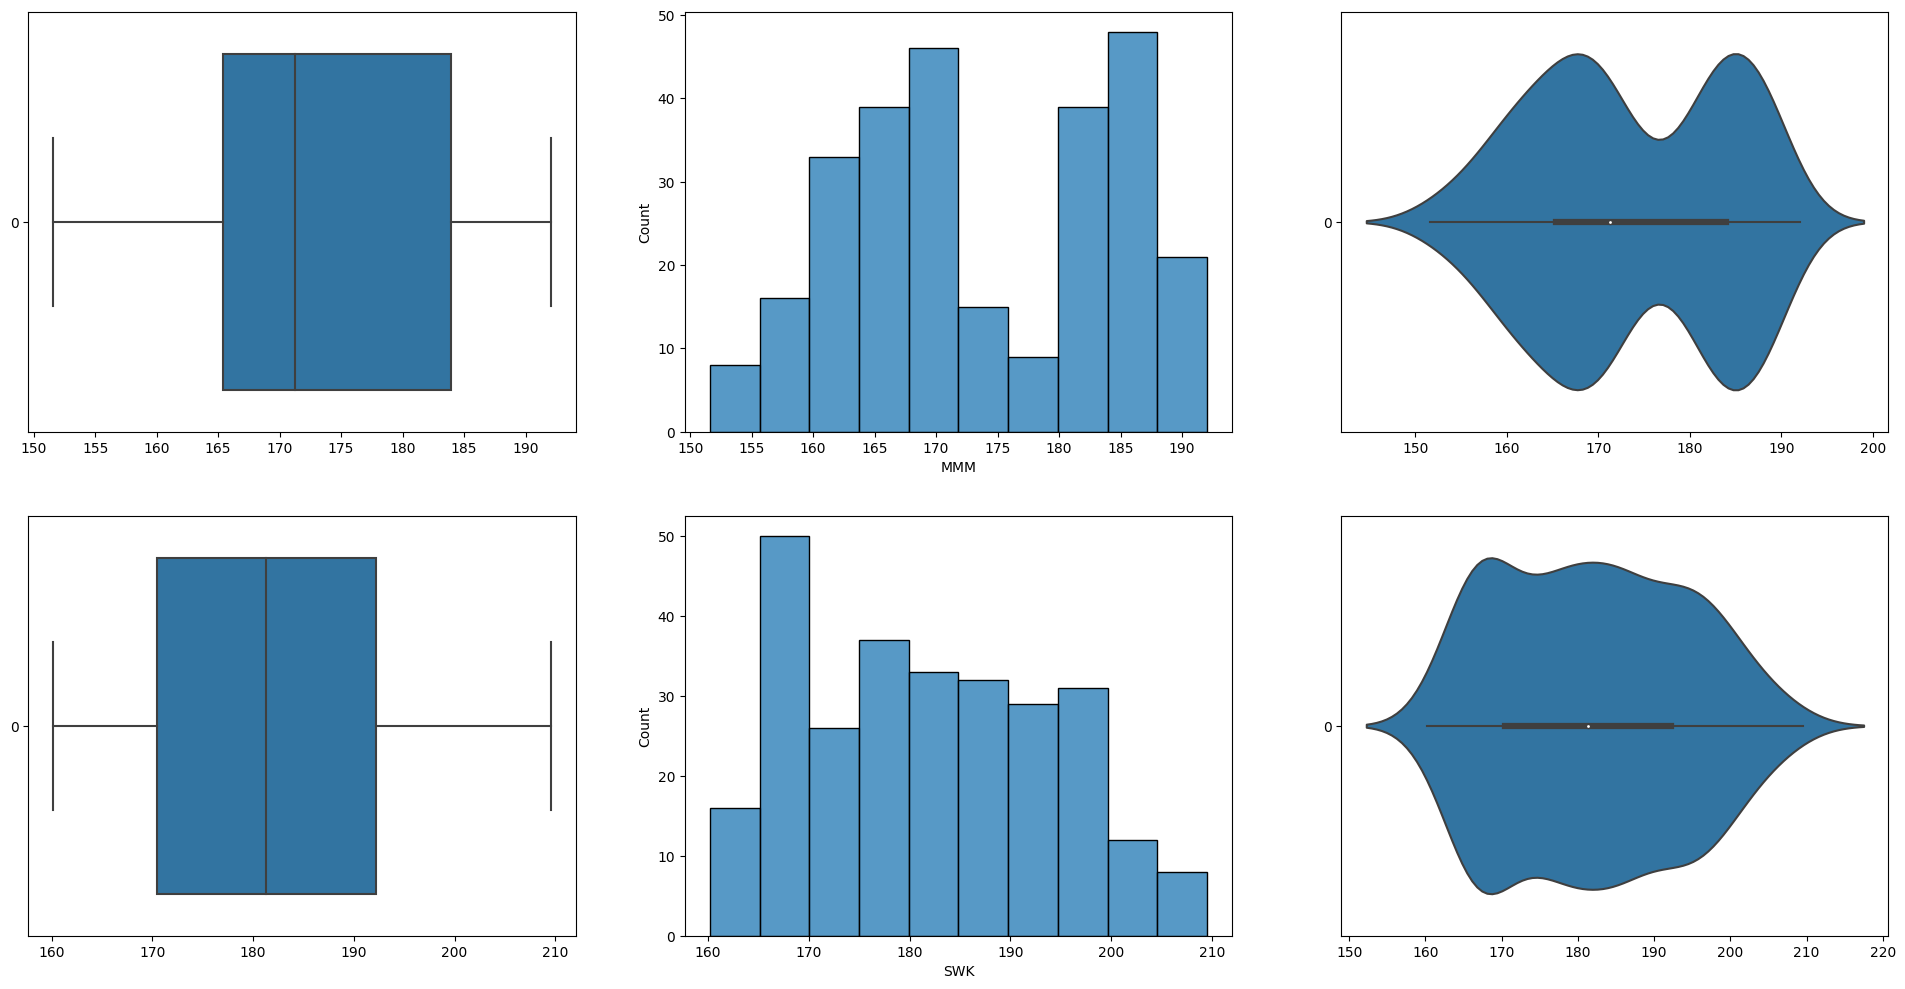

In [ ]:
MMM = d_year['MMM']
SWK = d_year['SWK']
f, axes = plt.subplots(2,3,figsize=(24,12))

sn.boxplot(data=MMM, orient='h', ax = axes[0,0])
sn.histplot(data=MMM, ax = axes[0,1])
sn.violinplot(data=MMM, orient='h', ax=axes[0,2])

sn.boxplot(data=SWK, orient='h', ax = axes[1,0])
sn.histplot(data=SWK, ax = axes[1,1])
sn.violinplot(data=SWK, orient='h', ax=axes[1,2])

Text(0.5, 1.0, 'Spread between 3M and SWK')

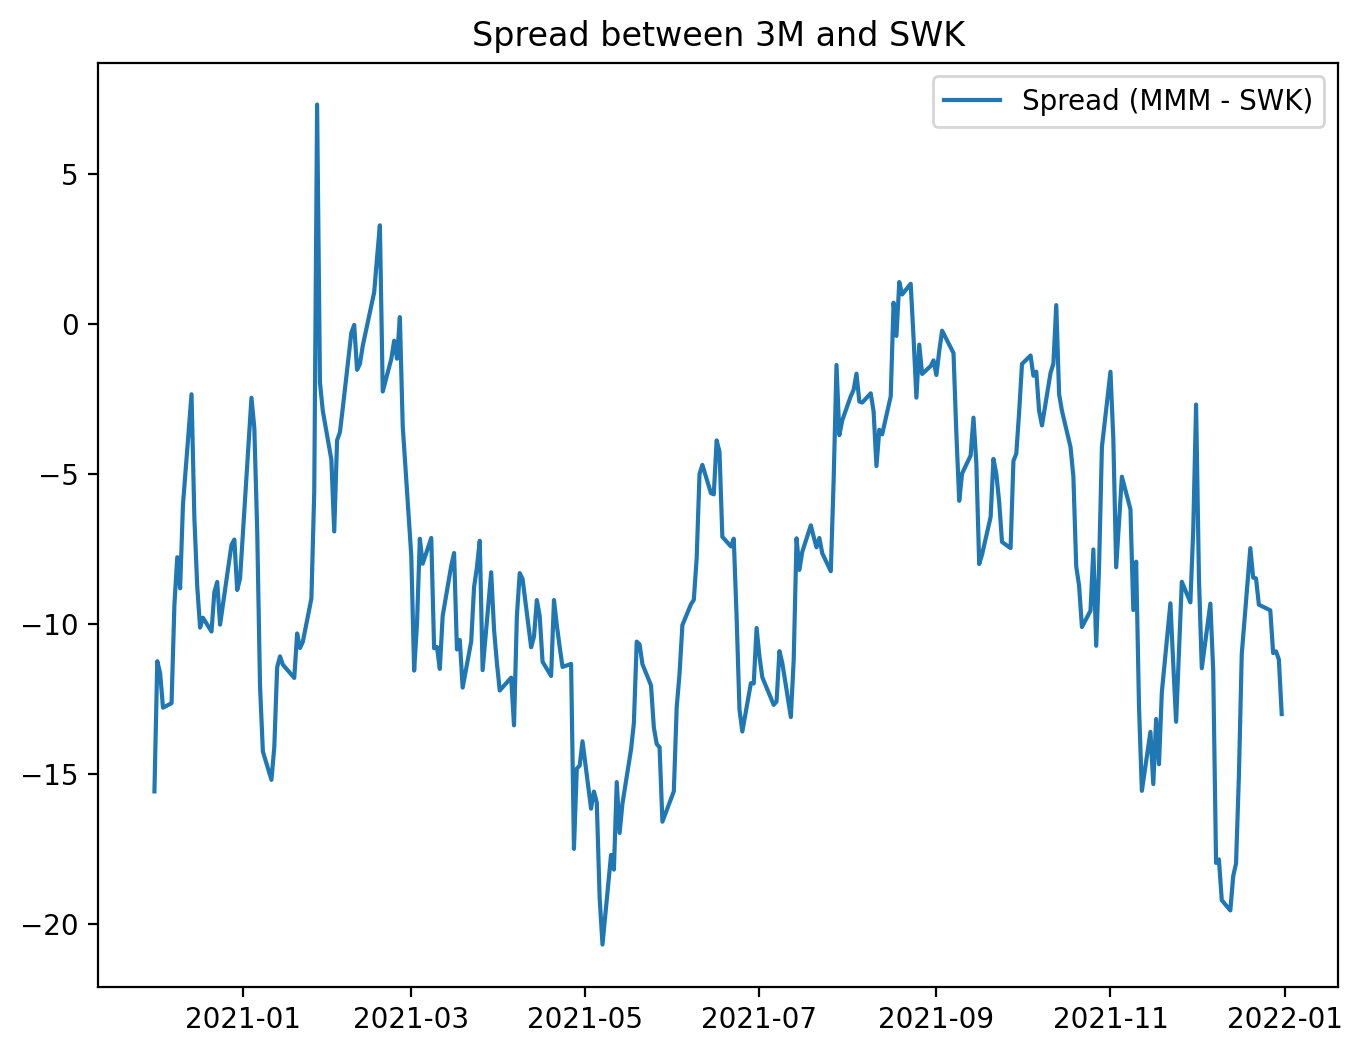

In [ ]:
# plot the spread
figure(figsize=(8, 6), dpi=200)
plt.plot(MMM - SWK, label = 'Spread (MMM - SWK)')
plt.legend()
plt.title("Spread between 3M and SWK")

From the correlation matrix generated, our observations support the conclusion of the K-Means clustering

<Axes: >

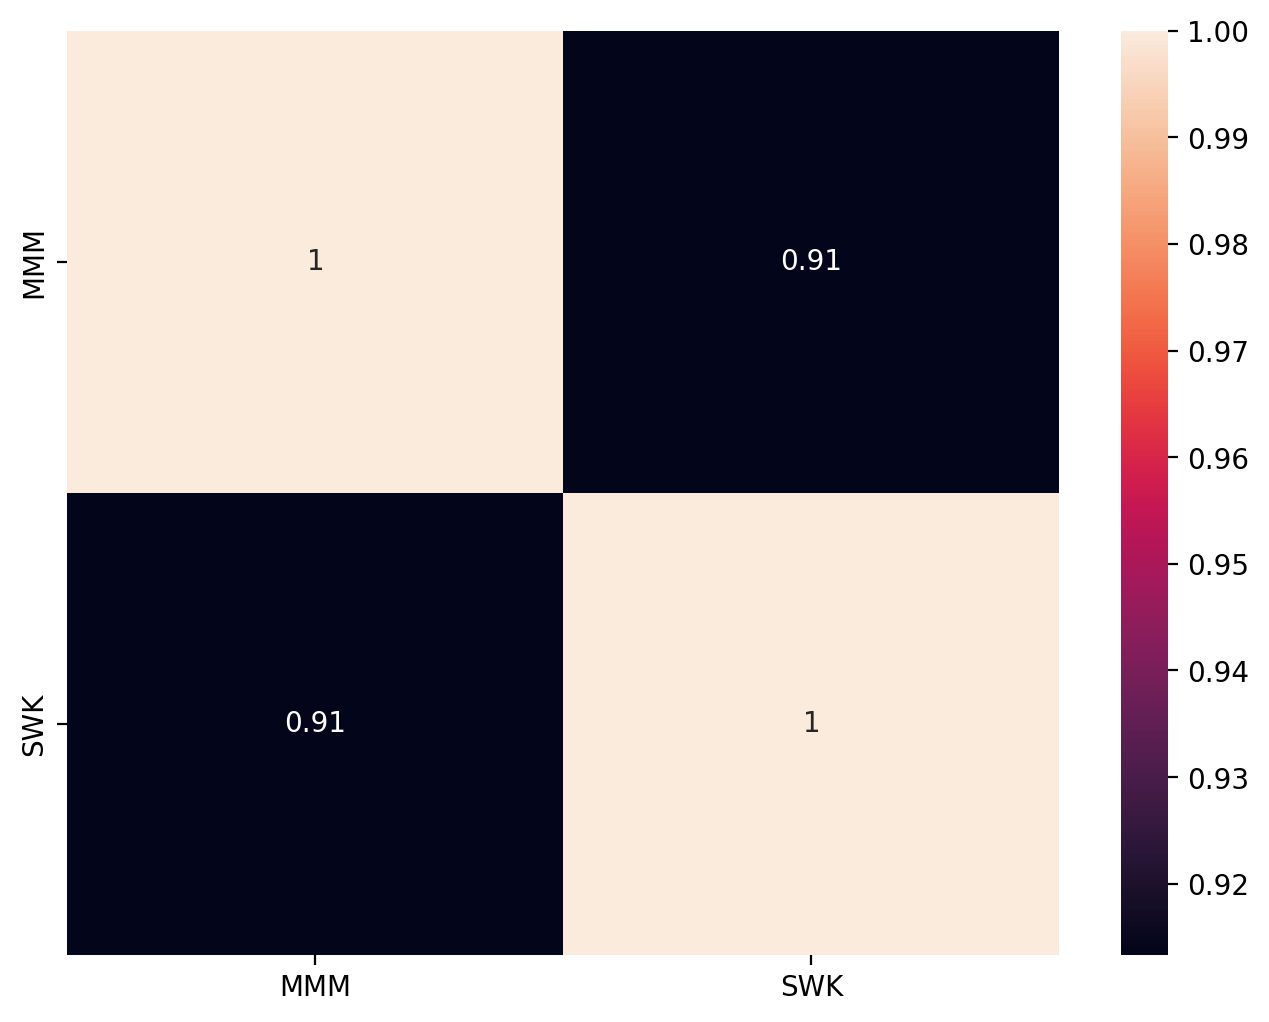

In [ ]:
d_year2 = d_year.loc[:,['MMM', 'SWK']]
corr_matrix = d_year2.corr()
figure(figsize=(8,6), dpi=200)
sn.heatmap(corr_matrix, annot=True)

Let's do a cointegration test to take a look at the p-value for our model.

In [ ]:
result = ts.coint(MMM, SWK)
cointegration_t_statistic = result[0]
p_val = result[1]
critical_values_test_statistic_at_1_5_10 = result[2]
print('We want the P val < 0.05 (meaning that cointegration exists)')
print('P value for the augmented Engle-Granger two-step cointegration test is', p_val)

We want the P val < 0.05 (meaning that cointegration exists)
P value for the augmented Engle-Granger two-step cointegration test is 0.00788838822805031


Given that the P val<0.05, we can conclude that MMM has a high degree of conintegration with SWK, which is beneficial for Pairs Trading

Let's test for stationarity now using the Augmented Dickey-Fuller Test. Recall that stationarity is our second condition to ensure that a pair is suitable for the implementation of the Pairs trading strategy.

In [ ]:
MMM_ADF = adfuller(MMM)
print('P value for the Augmented Dickey-Fuller Test is', MMM_ADF[1])
SWK_A_ADF = adfuller(SWK)
print('P value for the Augmented Dickey-Fuller Test is', SWK_A_ADF[1])
Spread_ADF = adfuller(MMM - SWK)
print('P value for the Augmented Dickey-Fuller Test is', Spread_ADF[1])
Ratio_ADF = adfuller(MMM / SWK)
print('P value for the Augmented Dickey-Fuller Test is', Ratio_ADF[1])

P value for the Augmented Dickey-Fuller Test is 0.4462898174681149
P value for the Augmented Dickey-Fuller Test is 0.32503258934409673
P value for the Augmented Dickey-Fuller Test is 0.0020194057238698783
P value for the Augmented Dickey-Fuller Test is 0.0008176465059829498


We can also see that the ADF for the spread and ratio are both <0.05 this allows us to conclude that MMM and SWK_A have a high degree of stationarity between them

From this point on, we will be using the price ratio of SWK against MMM to predict if a stock should be bought, sold or neither according to the principles of Pairs Trading

# Conduct Pairs Trading Strategy Implementation using Original Rolling Z-score Implementation

## Exploratory Analysis

Text(0.5, 1.0, 'Price Ratio between SWK price and MMM price')

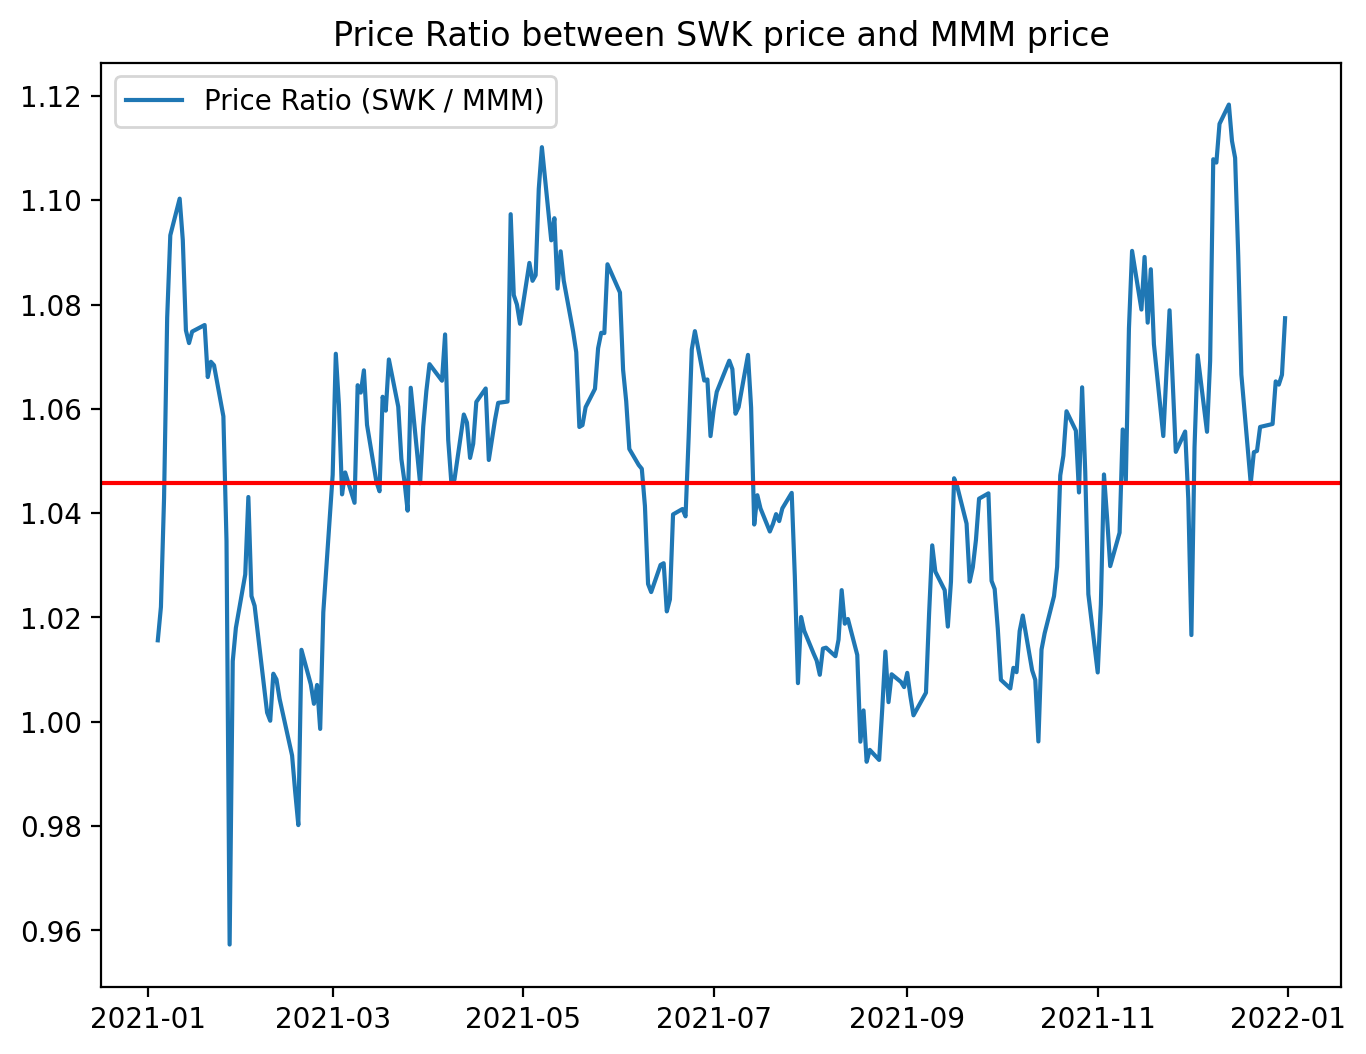

In [ ]:
# Let's take a closer look at the price ratios between the two time series.
figure(figsize=(8, 6), dpi=200)
ratio = SWK / MMM
ratio = ratio.loc['2021-01-01':'2022-01-01']
plt.plot(ratio, label = 'Price Ratio (SWK / MMM)')
plt.axhline(ratio.mean(), color='red')
plt.legend()
plt.title("Price Ratio between SWK price and MMM price")

From the graph, we can observe the stationarity between SWK_A and MMM and can see that the values vary about a mean slightly above 1.00

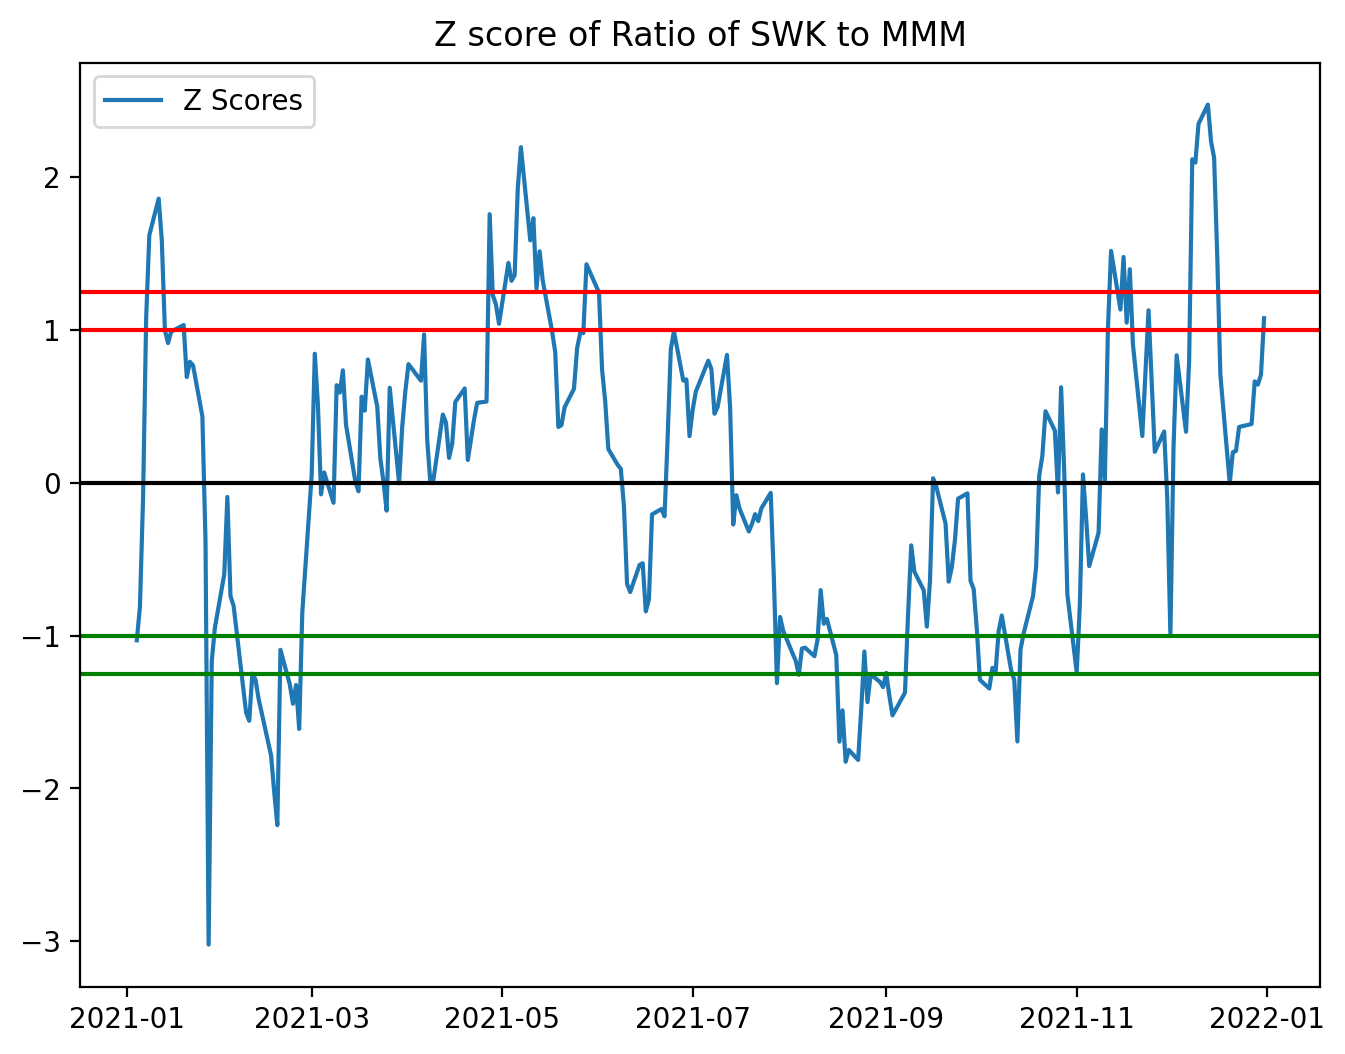

In [ ]:
# Note, we can either use the spread or the Price ratio approach. 
# Anyways, let's standardize the ratio so we can have a 
# upper and lower bound to help evaluate our trends.. Let's stick with the ratio data.
figure(figsize=(8, 6), dpi=200)
# Calculate the Zscores of each row.
df_zscore = (ratio - ratio.mean())/ratio.std()
plt.plot(df_zscore, label = "Z Scores")
plt.axhline(df_zscore.mean(), color = 'black')
plt.axhline(1.0, color='red') # Setting the upper and lower bounds to be the z score of 1 and -1 (1/-1 standard deviation)
plt.axhline(1.25, color='red') # 95% of our data will lie between these bounds.
plt.axhline(-1.0, color='green') # 68% of our data will lie between these bounds.
plt.axhline(-1.25, color='green') # 95% of our data will lie between these bounds.
plt.legend(loc = 'best')
plt.title('Z score of Ratio of SWK to MMM')
plt.show()
# For the most part, the range that exists outside of these 'bands' must come converge back to the mean. Thus, you can 
# determine when you can go long or short the pair (BRK_B to MSFT).

By calculating and plotting the Z-Scores for the ratio, we are able to determine the upper and lower bands which we will be using to determine if the stock SWK should be bought or sold

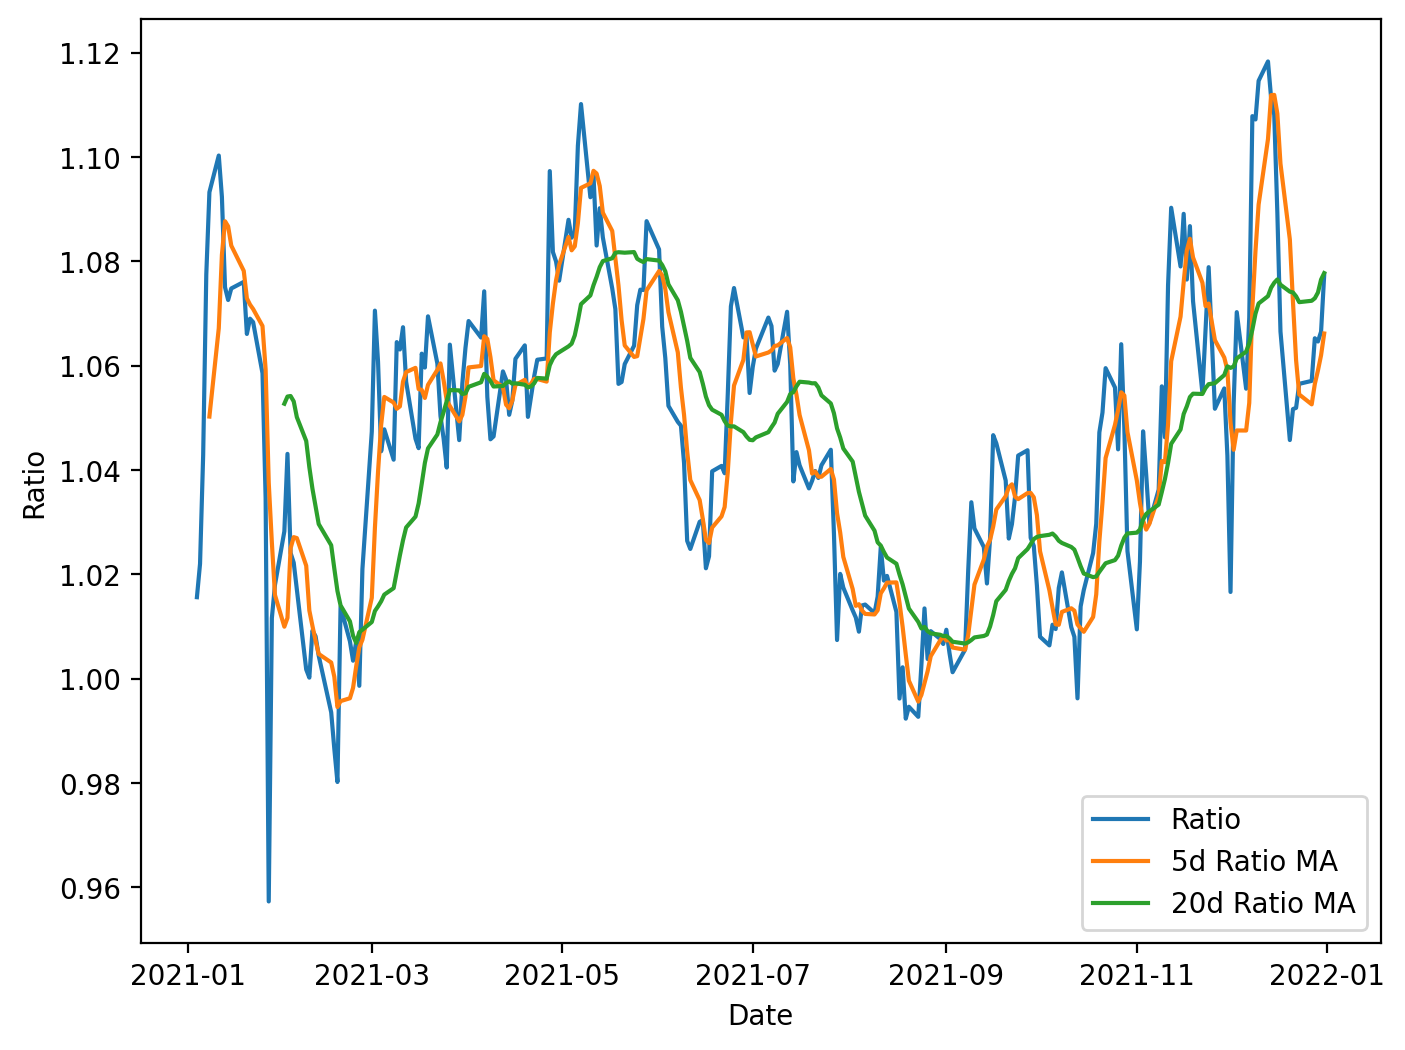

In [ ]:
figure(figsize=(8, 6), dpi=200)
ratios_mavg5 = ratio.rolling(window=5, center=False).mean()
ratios_mavg20 = ratio.rolling(window=20, center=False).mean()
std_20 = ratio.rolling(window=20, center=False).std()
zscore_20_5 = (ratios_mavg5 - ratios_mavg20)/std_20
plt.plot(ratio.index, ratio.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg20.index, ratios_mavg20.values)
plt.legend(['Ratio', '5d Ratio MA', '20d Ratio MA'])
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.show()

A better way to access if SWK should be bought or sold is by using the 5 and 20 day Moving Averages to appoximate the ratio of the stocks. Doing so will allow us to have a better indicator of the stock's recent trends, better informing our decisions to buy or sell

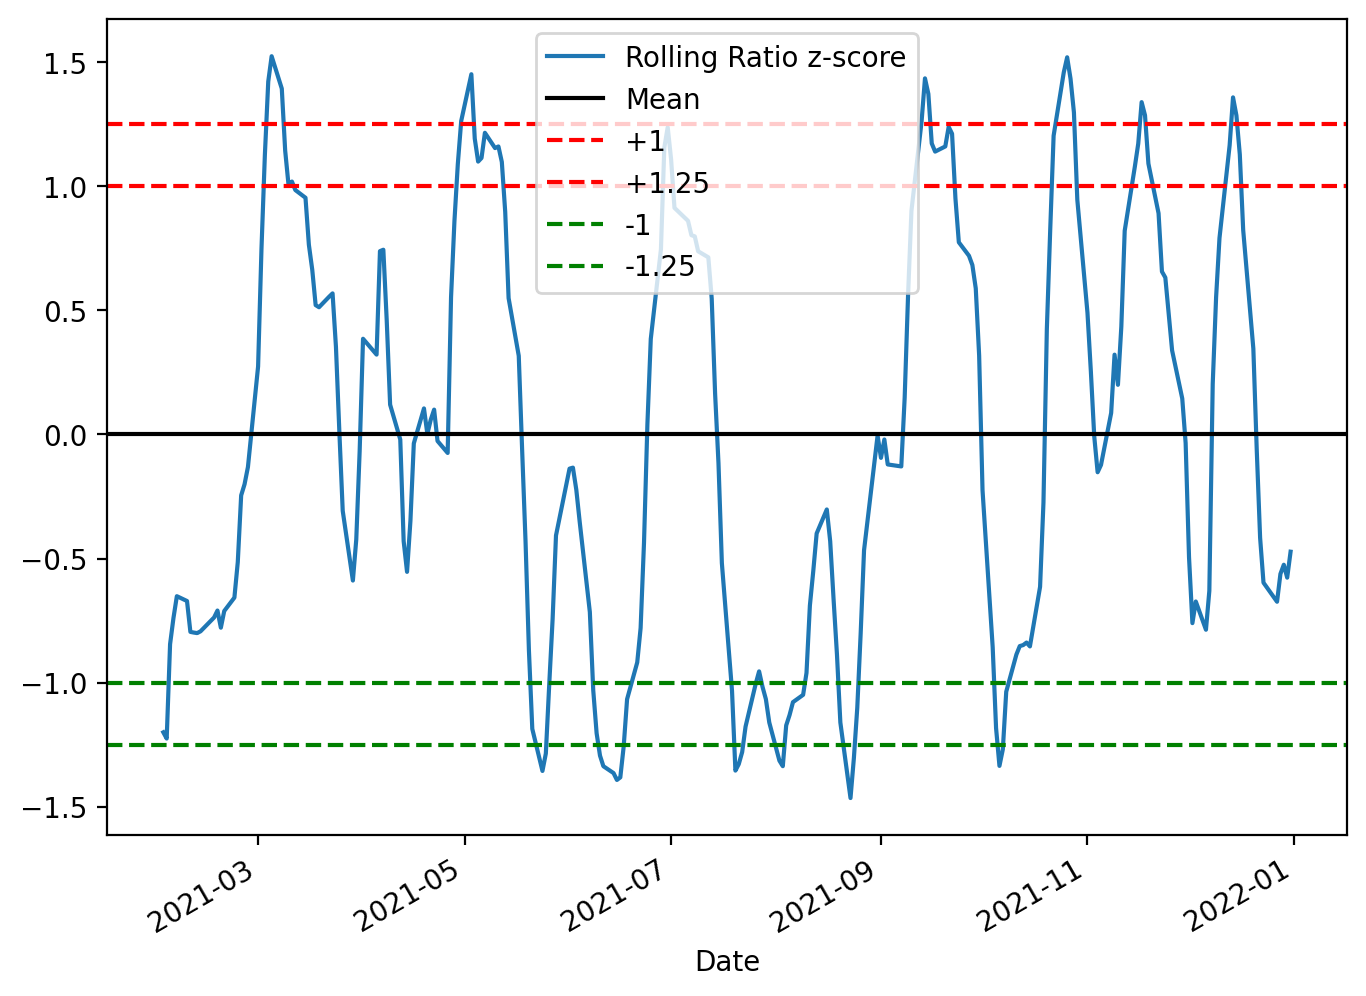

In [ ]:
figure(figsize=(8, 6), dpi=200)
zscore_20_5.plot()
plt.axhline(0, color='black')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(1.25, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.axhline(-1.25, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-score', 'Mean', '+1','+1.25','-1','-1.25'])
plt.show()

Calculating a Z-Score using the 5 and 20 day MA allows us to come up with new 

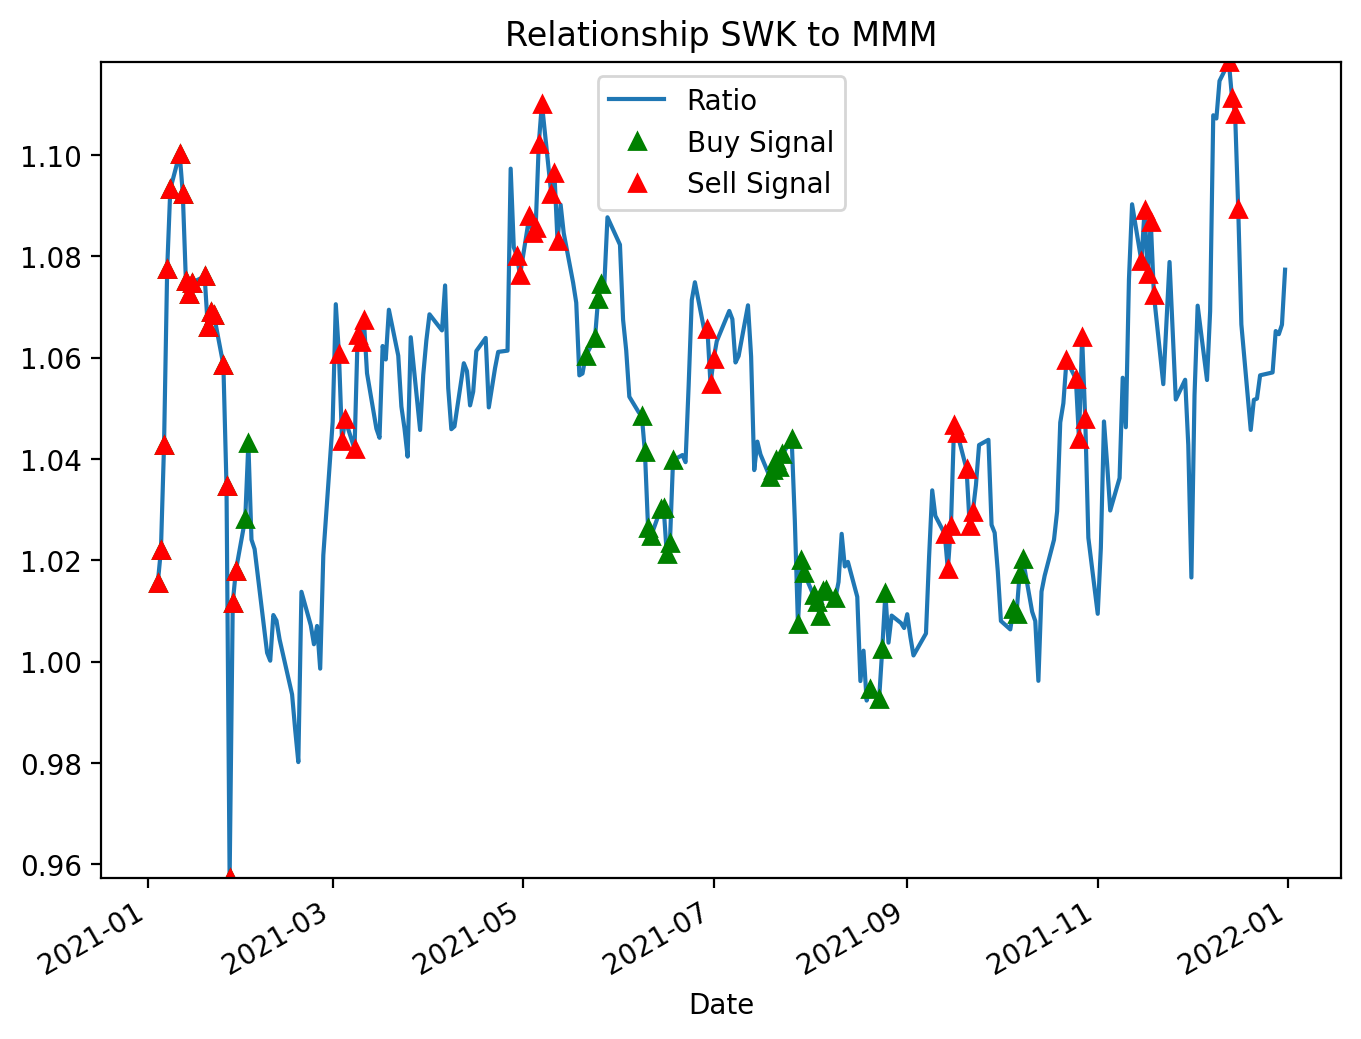

In [ ]:
figure(figsize=(8, 6), dpi=200)
ratio.plot()
buy = ratio.copy()
sell = ratio.copy()
buy[zscore_20_5>-1] = 0
sell[zscore_20_5<1] = 0
buy.plot(color='g', linestyle='None', marker='^')
sell.plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratio.min(), ratio.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.title('Relationship SWK to MMM')
plt.show()

## Profit/ Loss Calculation using Z-score method 

Let's now try out the Z-score Pairs Trading strategy on our stock data from 2022 onwards to see our profit/loss. We first define a simple trading strategy for us to simulate profit and loss. 

In [109]:
# Trade using a simple strategy
def trade(S1, S2, indicator, counter):
  
  # Simulate trading
  ratios = S1/S2

  # Start with no money and no positions
  money = 0
  countS1 = 0
  countS2 = 0
  clear_count = 0
  for i in range(len(S1)):
    # Sell short if indicator is Sell
    if indicator[i] == 'Sell':
      money += S1[i] - S2[i] * ratios[i]
      countS1 -= 1
      countS2 += ratios[i]
      clear_count = 0
      # print('Selling Ratio, Money: %s Ratio: %s Stock 1: %s Stock 2: %s'%(money, ratios[i], countS1,countS2))
    # Buy long if indicator is Buy
    elif indicator[i] == 'Buy':
      money -= S1[i] - S2[i] * ratios[i]
      countS1 += 1
      countS2 -= ratios[i]
      clear_count = 0
      # print('Buying Ratio, Money: %s Ratio: %s Stock 1: %s Stock 2: %s'%(money,ratios[i], countS1,countS2))
    # Clear positions if 'None' signal appears too many times 
    elif clear_count > counter:
      money += S1[i] * countS1 + S2[i] * countS2
      countS1 = 0
      countS2 = 0
      clear_count = 0
      # print('Exit pos, Money: %s Ratio: %s Stock 1: %s Stock 2: %s'%(money,ratios[i], countS1,countS2))
    elif indicator[i] == 'None':
      clear_count += 1

            
  return money

We define a new function get_historicalData2 which calls the yahoo finance API to give us the relevant dataset for data from 2022 onwards. 

In [ ]:
def get_historical_Data2(tickers):
    """This function returns a pd dataframe with all of the adjusted closing information"""
    data = pd.DataFrame()
    names = list()
    for i in tickers:
        data = pd.concat([data, pd.DataFrame(yf.download(i, start=datetime(2021, 12, 1), end=datetime(2023, 1, 1)).iloc[:,4])], axis = 1)
        names.append(i)
    data.columns = names
    return data

We now perform our prior calculations to obtain a clear buy/sell signal for us to apply our trading function to.

In [ ]:
def buysell(x):
    if x >=1:
        return "Sell"
    elif x<=-1: 
        return "Buy"
    else:
        return "None"

In [ ]:
d_test = get_historical_Data2(['MMM', 'SWK'])

df2 = d_test.copy(deep=True)
df2['Ratio'] = df2['SWK']/df2['MMM']
df2['ratios_mavg5'] = df2['Ratio'].rolling(window=5, center=False).mean()
df2['ratios_mavg20'] = df2['Ratio'].rolling(window=20, center=False).mean()
df2['std_20'] = df2['Ratio'].rolling(window=20, center=False).std()
df2['zscore_20_5'] = (df2['ratios_mavg5']-df2['ratios_mavg20'])/df2['std_20']
df2["PairsTrading"] = df2['zscore_20_5'].apply(buysell)
df2 = df2.loc["2022-01-01":]
df2

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


MMM         SWK     Ratio  ratios_mavg5  ratios_mavg20  \
Date                                                                        
2022-01-03  168.282089  178.606888  1.061354      1.067033       1.077316   
2022-01-04  170.639603  184.610703  1.081875      1.070355       1.078630   
2022-01-05  169.938995  183.823013  1.081700      1.073765       1.079255   
2022-01-06  168.528259  184.918121  1.097253      1.079912       1.078725   
2022-01-07  170.374496  181.834549  1.067264      1.077889       1.076727   
...                ...         ...       ...           ...            ...   
2022-12-23  118.570084   73.262115  0.617880      0.610766       0.630763   
2022-12-27  118.649040   73.727814  0.621394      0.612085       0.629993   
2022-12-28  116.744263   71.518250  0.612606      0.610568       0.628900   
2022-12-29  118.994469   75.214058  0.632080      0.617821       0.627940   
2022-12-30  118.352959   74.431297  0.628893      0.622571       0.626586   

              std_20  zscore_20_5 PairsTrading  
Date                                            
2022-01-03  0.024732    -0.415786         None  
2022-01-04  0.024210    -0.341796         None  
2022-01-05  0.024115    -0.227642         None  
2022-01-06  0.023563     0.050372         None  
2022-01-07  0.022699     0.051199         None  
...              ...          ...          ...  
2022-12-23  0.016306    -1.226386          Buy  
2022-12-27  0.016370    -1.094020          Buy  
2022-12-28  0.016780    -1.092500          Buy  
2022-12-29  0.015961    -0.633983         None  
2022-12-30  0.014544    -0.276103         None  

[251 rows x 8 columns]

We now call the trade function below to find out our maximum profit and loss from our initial model.

In [ ]:
max_i = []

for i in range(100):
    max_i.append(trade(df2['SWK'],df2['MMM'],df2['PairsTrading'], i))

print('Max amount made from Pairs Trading using Z-score method: ' + str(round(max(max_i),2)))
print('Number of days for clearance: ' + str(max_i.index(max(max_i))))

Max amount made from Pairs Trading using Z-score method: 293.87
Number of days for clearance: 9


 As we can see, using the standard Z-score method, we obtain a profit of $440.26. We will use the optimal interval of 9 days as found here before clearing our positions in our subsequent calculations.

# Conduct Pairs Trading Strategy using Decision Trees

In [ ]:
df = d_year.loc[:, ['SWK', 'MMM']]
df['Ratio'] = df['SWK']/df['MMM']
df['ratios_mavg5'] = df['Ratio'].rolling(window=5, center=False).mean()
df['ratios_mavg20'] = df['Ratio'].rolling(window=20, center=False).mean()
df['std_20'] = df['Ratio'].rolling(window=20, center=False).std()
df['zscore_20_5'] = (df['ratios_mavg5']-df['ratios_mavg20'])/df['std_20']
df["PairsTrading"] = df['zscore_20_5'].apply(buysell)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# df[df['PairsTrading']=="Buy"]
df = df.loc["2021-01-01":"2022-01-01"]

In [ ]:
df = df.round(4)
df

SWK       MMM   Ratio  ratios_mavg5  ratios_mavg20  std_20  \
Date                                                                          
2021-01-04  160.1814  157.7182  1.0156        1.0430         1.0523  0.0168   
2021-01-05  160.9192  157.4521  1.0220        1.0382         1.0494  0.0167   
2021-01-06  166.6984  159.8472  1.0429        1.0378         1.0475  0.0149   
2021-01-07  167.8145  155.7453  1.0775        1.0422         1.0484  0.0162   
2021-01-08  167.1618  152.9005  1.0933        1.0503         1.0506  0.0191   
...              ...       ...     ...           ...            ...     ...   
2021-12-27  176.8490  167.2974  1.0571        1.0526         1.0725  0.0294   
2021-12-28  179.1640  168.1874  1.0653        1.0565         1.0729  0.0292   
2021-12-29  179.8365  168.9164  1.0646        1.0591         1.0740  0.0284   
2021-12-30  179.3754  168.1874  1.0665        1.0620         1.0765  0.0251   
2021-12-31  181.1909  168.1780  1.0774        1.0662         1.0778  0.0245   

            zscore_20_5 PairsTrading  
Date                                  
2021-01-04      -0.5533         None  
2021-01-05      -0.6676         None  
2021-01-06      -0.6464         None  
2021-01-07      -0.3816         None  
2021-01-08      -0.0194         None  
...                 ...          ...  
2021-12-27      -0.6743         None  
2021-12-28      -0.5622         None  
2021-12-29      -0.5251         None  
2021-12-30      -0.5772         None  
2021-12-31      -0.4725         None  

[252 rows x 8 columns]

In [ ]:
# Set up train test sets
train = df.loc[:"2021-08-01"]
test = df.loc["2021-08-01":]
x_train = pd.DataFrame(train['Ratio'])
x_test = pd.DataFrame(test['Ratio'])
y_train = pd.DataFrame(train['PairsTrading'])
y_test = pd.DataFrame(test['PairsTrading'])

In [ ]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [ ]:
y_train_pred = dt.predict(x_train)
y_test_pred = dt.predict(x_test)

[Text(0.5, 0.8333333333333334, 'Buy Or Sell <= 1.075\ngini = 0.505\nsamples = 145\nvalue = [25, 96, 24]\nclass = None'),
 Text(0.25, 0.5, 'Buy Or Sell <= 1.044\ngini = 0.458\nsamples = 120\nvalue = [25, 84, 11]\nclass = None'),
 Text(0.125, 0.16666666666666666, 'gini = 0.518\nsamples = 52\nvalue = [20, 30, 2]\nclass = None'),
 Text(0.375, 0.16666666666666666, 'gini = 0.346\nsamples = 68\nvalue = [5, 54, 9]\nclass = None'),
 Text(0.75, 0.5, 'Buy Or Sell <= 1.101\ngini = 0.499\nsamples = 25\nvalue = [0, 12, 13]\nclass = Sell'),
 Text(0.625, 0.16666666666666666, 'gini = 0.499\nsamples = 23\nvalue = [0, 12, 11]\nclass = None'),
 Text(0.875, 0.16666666666666666, 'gini = 0.0\nsamples = 2\nvalue = [0, 0, 2]\nclass = Sell')]

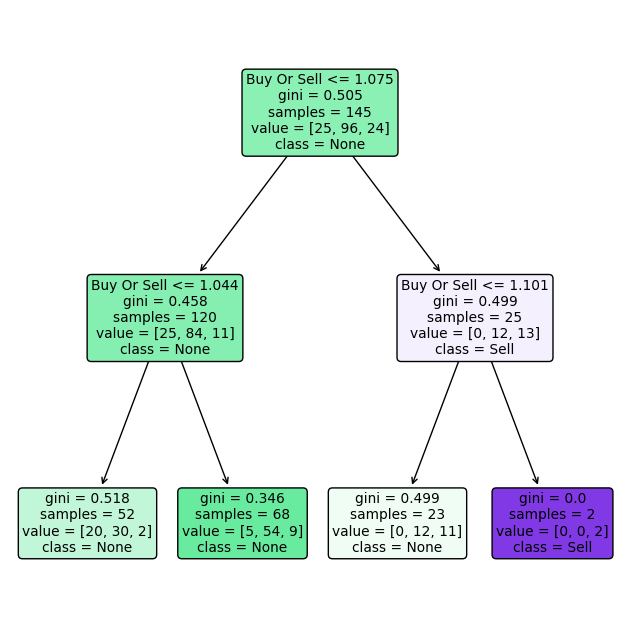

In [ ]:

f = plt.figure(figsize=(8,8))
plot_tree(dt, filled=True, rounded=True, 
          feature_names=["Buy Or Sell"], 
          class_names=["Buy","None","Sell"])

In [ ]:
from sklearn.metrics import confusion_matrix
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dt.score(x_train, y_train))

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dt.score(x_test, y_test))

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.6758620689655173
Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6635514018691588


As expected, simple indicators such as the share price ratio are unable to predict as well as our z-score indicator. We will expand further on how we can better identify a set of indicators that can predict with the same accuracy as z-score in later portions. For now, let's test our decision tree model on 2022 stock data to explore our results.

### Testing model on 2022 stock data


In [38]:
d_test = get_historical_Data2(['MMM', 'SWK'])
d2_year = d_test.loc["2022-01-01":]
d2_year

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


MMM         SWK
Date                              
2022-01-03  168.282104  178.606873
2022-01-04  170.639587  184.610718
2022-01-05  169.938980  183.823013
2022-01-06  168.528259  184.918106
2022-01-07  170.374496  181.834564
...                ...         ...
2022-12-23  118.570084   73.262115
2022-12-27  118.649040   73.727814
2022-12-28  116.744263   71.518250
2022-12-29  118.994469   75.214058
2022-12-30  118.352959   74.431297

[251 rows x 2 columns]

In [39]:
df2 = d2_year.copy(deep=True)
df2['Ratio'] = df2['SWK']/df2['MMM']
df2['ratios_mavg5'] = df2['Ratio'].rolling(window=5, center=False).mean()
df2['ratios_mavg20'] = df2['Ratio'].rolling(window=20, center=False).mean()
df2['std_20'] = df2['Ratio'].rolling(window=20, center=False).std()
df2['zscore_20_5'] = (df2['ratios_mavg5']-df2['ratios_mavg20'])/df2['std_20']
df2["PairsTrading"] = df2['zscore_20_5'].apply(buysell)

After adjusting our dataframe for the 2022 data, we can see that the decision tree accuracy is 0.670.

In [ ]:
ratio_test = pd.DataFrame(df2['Ratio'])
results_test = pd.DataFrame(df2['PairsTrading'])
print("Classification Accuracy \t:", dt.score(ratio_test, results_test))

Classification Accuracy 	: 0.6693227091633466


In [ ]:
PairsTrading_ratioPrediction = dt.predict(ratio_test)
df2['PairsTrading_ratioPrediction'] = PairsTrading_ratioPrediction

Text(0.5, 1.0, 'Price Ratio between SWK and MMM 2022')

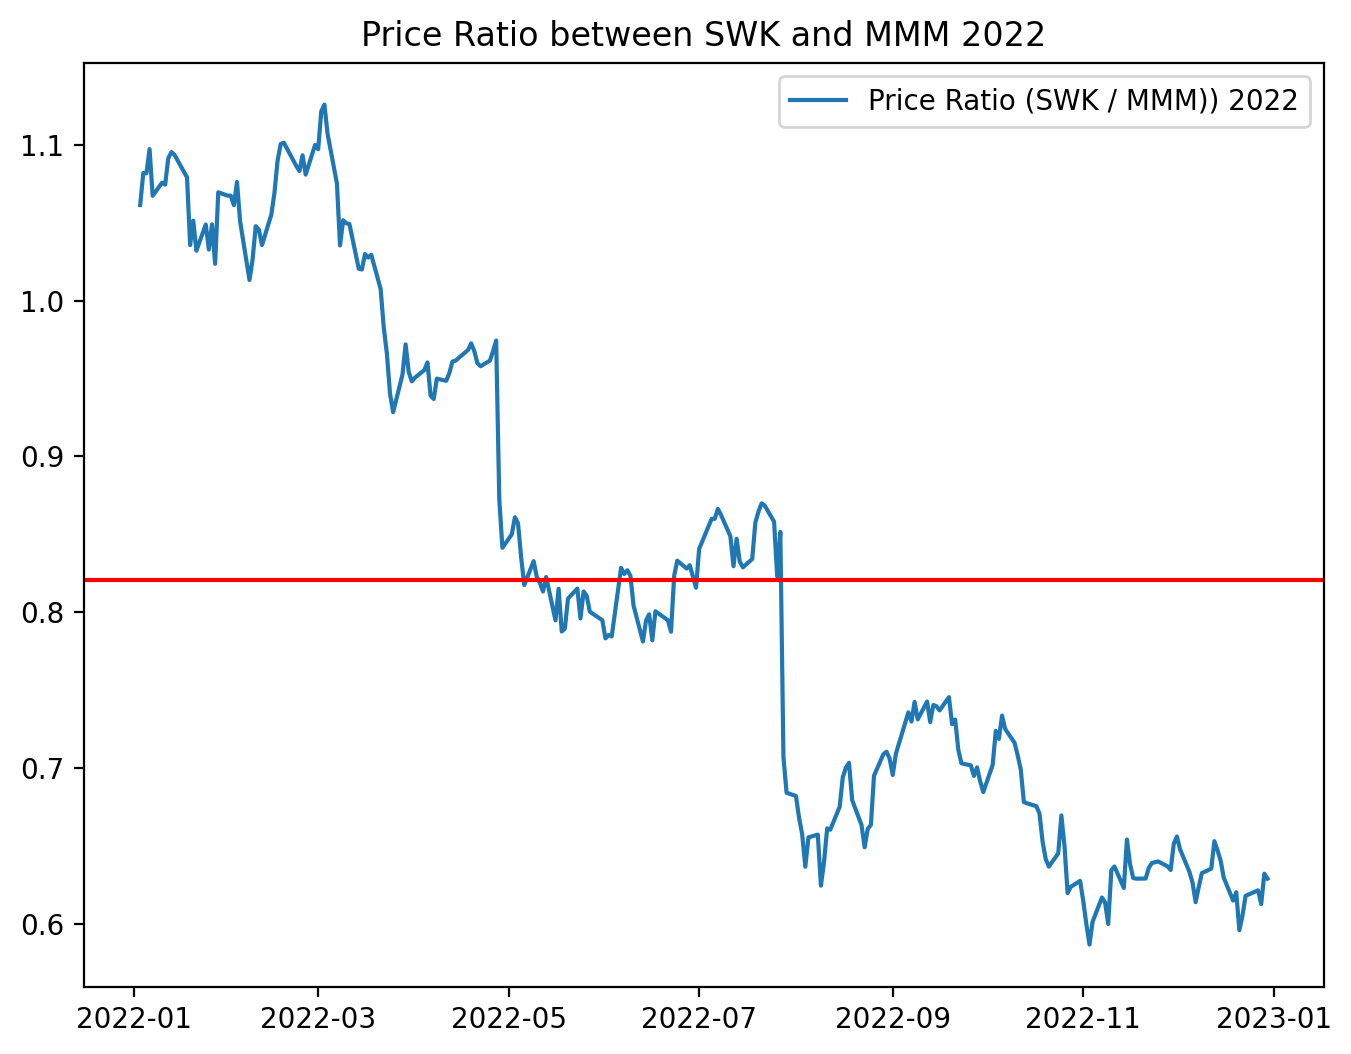

In [ ]:
figure(figsize=(8, 6), dpi=200)
plt.plot(df2['Ratio'], label = 'Price Ratio (SWK / MMM)) 2022')
plt.axhline(df2['Ratio'].mean(), color='red')
plt.legend()
plt.title("Price Ratio between SWK and MMM 2022")

In [ ]:
ratio_df = pd.DataFrame(df2['Ratio'])
buy = df2[df2['PairsTrading_ratioPrediction']=='Buy']
buy = pd.DataFrame(buy['Ratio'])

sell = df2[df2['PairsTrading_ratioPrediction']=='Sell']
sell = pd.DataFrame(sell['Ratio'])

merged_df = pd.merge(ratio_df, buy, on='Date', how='outer')
merged_df2 = pd.merge(merged_df, sell, on='Date', how='outer')

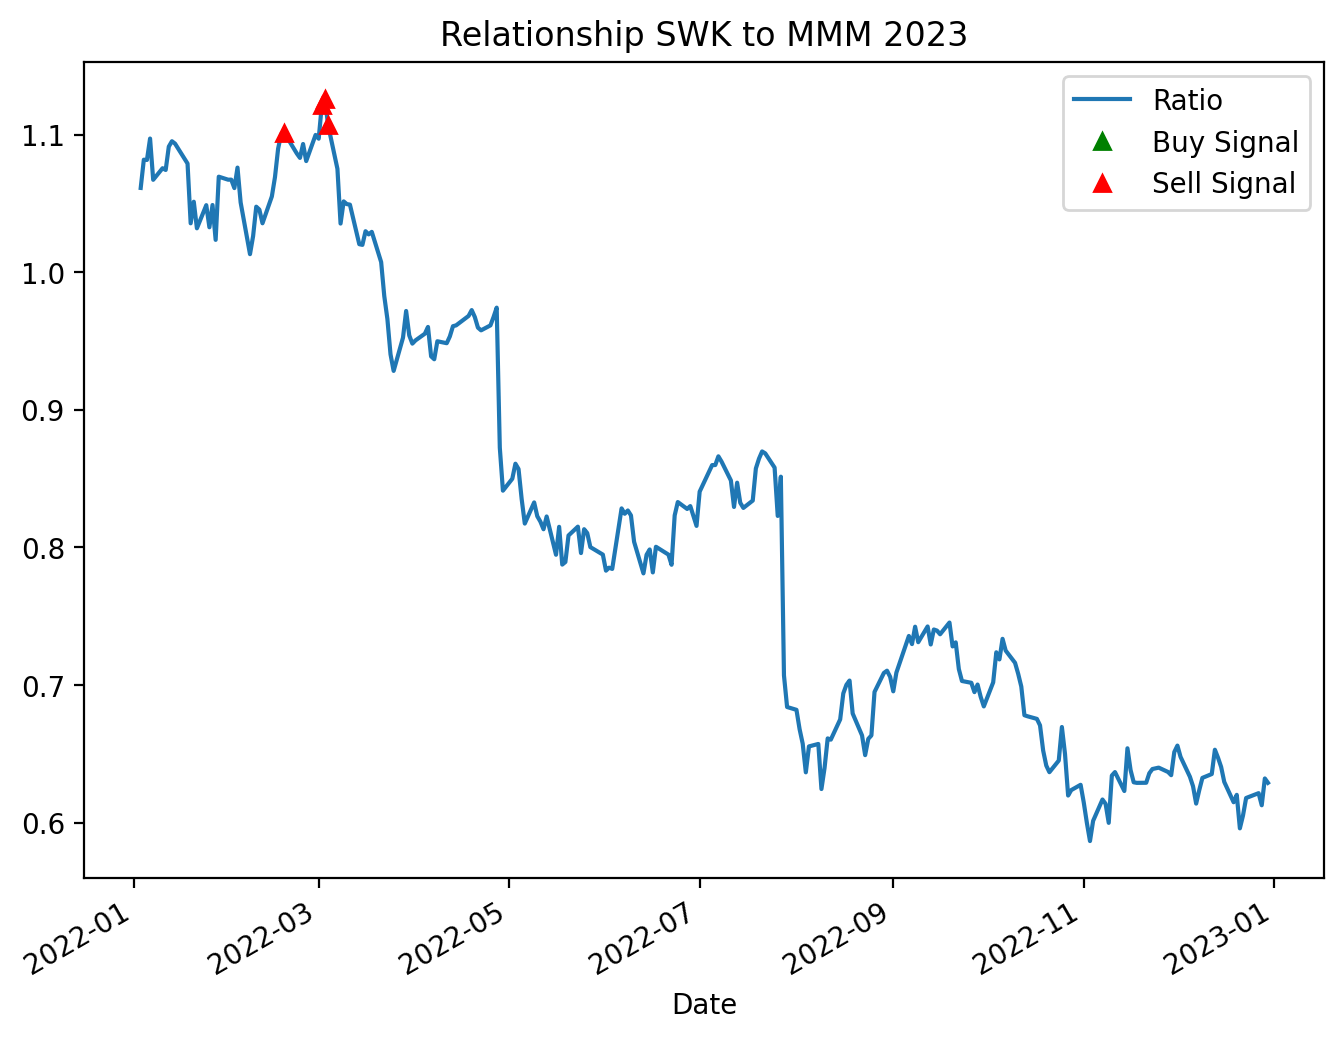

In [ ]:
figure(figsize=(8, 6), dpi=200)
merged_df2['Ratio_x'].plot()
merged_df2['Ratio_y'].plot(color='g', linestyle='None', marker='^')
merged_df2['Ratio'].plot(color='r', linestyle='None', marker='^')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.title('Relationship SWK to MMM 2023')
plt.show()

From the trade signals above, we can see that the decision tree approach is not the most accurate. The signals are clustered near the start of 2022 and mostly involve only sell signals. If this were to be implemented in a real world scenario, this tree will not hold water. For now, let's measure the profitability of this approach for comparison later on.

### Profit/ Loss Calculation using Decision Trees



Now, we call our trade function again to find out the profit generated by the decision trees method.

In [ ]:
trade(df2['SWK'],df2['MMM'],df2['PairsTrading_ratioPrediction'], 10)

75.23160780153296

From an initial observation, the decision trees method generates a much lower profit as compared to the pure Z-score method. As stated above, we can see that the trade signals are clustered near the start of 2022, with the majority of signals being sell signals. Therefore, the profit generated by the decision trees method can be attributed to the fact that the decision trees aggressively shorted the stock ratio. 

Given that the premise of Pairs Trading is that of a market neutral strategy, while the profit is significantly more than the z-score method, we cannot objectively say that this is a better strategy. The classification accuracy and the profitability both do not really support this approach.

# Conduct Pairs Trading Strategy Implementation using Random Forest

Our observations suggest that a single decison tree can be limited in prediction accuracy, especially if the attribute chosen does not have a high correlation with the resulting variable.

Hence we decided to use a different ML model to see if it had better success predicting if a stock should be bought or sold. The Model we chose was a random forest model, which uses a series of decision trees to predict PairsTrading. By doing so, we incorporate a wide variety of stock indicators. This avoids the limitations of just using a single variable and allows for greater prediction accuracy.

## Data Preparation

We will once again be using the same two stocks MMM and SWK in the same timeframe of 01-01-2021 to 31-12-2021.

In [ ]:
p = get_historical_Data(["MMM", "SWK"])
pd.set_option('display.max_rows', 60)
p

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


MMM         SWK
Date                              
2020-12-01  156.479385  172.070847
2020-12-02  157.699844  168.949524
2020-12-03  157.681519  169.327850
2020-12-04  158.259628  171.058807
2020-12-07  156.139832  168.788696
...                ...         ...
2021-12-27  167.297440  176.848969
2021-12-28  168.187408  179.164032
2021-12-29  168.916458  179.836472
2021-12-30  168.187408  179.375381
2021-12-31  168.177979  181.190933

[274 rows x 2 columns]

The graph below gives us an idea of how MMM Augmented and SWK looks like after agumenting the values of MMM. As previously calculated, we can see that the values of their stocks are closely correlated and have high stationarity.

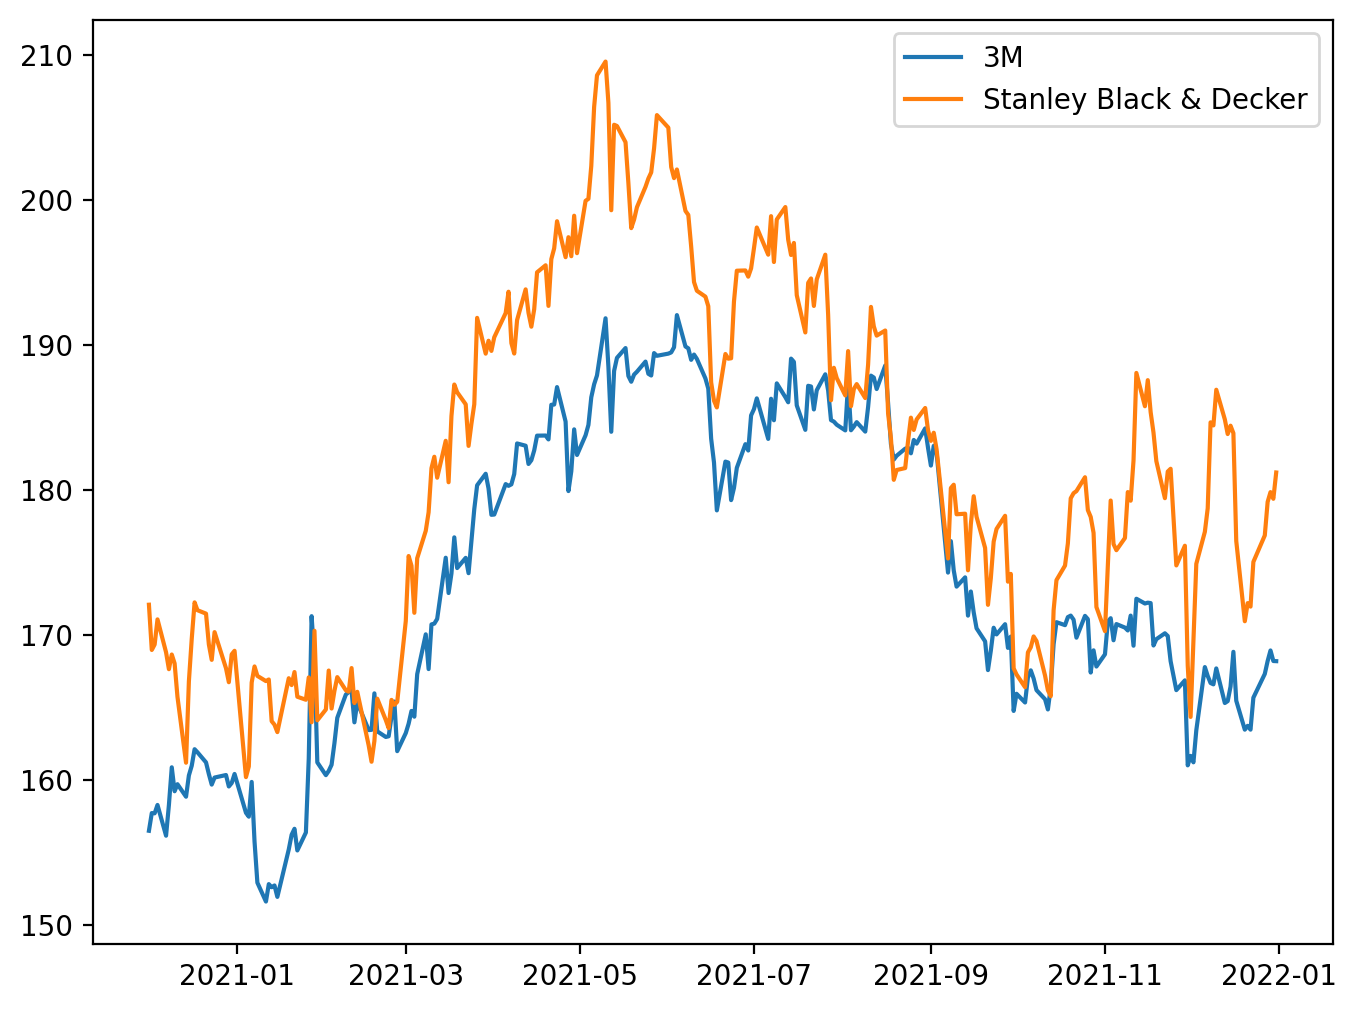

In [ ]:
figure(figsize=(8, 6), dpi=200)
SWK = p['SWK'] # SWK Augmented
MMM = p['MMM'] # 3M
plt.plot(MMM, label = "3M")
plt.plot(SWK, label = "Stanley Black & Decker")
plt.legend()

We can observe the new values of MMM as compared to SWK

In [ ]:
p

MMM         SWK
Date                              
2020-12-01  156.479385  172.070847
2020-12-02  157.699844  168.949524
2020-12-03  157.681519  169.327850
2020-12-04  158.259628  171.058807
2020-12-07  156.139832  168.788696
...                ...         ...
2021-12-27  167.297440  176.848969
2021-12-28  168.187408  179.164032
2021-12-29  168.916458  179.836472
2021-12-30  168.187408  179.375381
2021-12-31  168.177979  181.190933

[274 rows x 2 columns]

## Exploratory Analysis

Using the ratios of MMM against SWK and the Moving Averages, we calculate the predicted PairsTrading once again using Rolling Zscore

We then calculate other stock indicators using Ratio and the 20 Day Moving Average, such as the upper and lower bollinger bands, the Ratio RSI, Ratio MACD and Ratio HMA. These indicators are all different measurements to quantify the performance of MMM vs SWK and are used in industry to compare the performaces of different stocks.

We will be using these values, along with the Ratio, 5 and 20 day MA and the calculated standard deviation in the random forest.

In [ ]:
p['Ratio'] = p['SWK']/p['MMM']
p['ratios_mavg5'] = p['Ratio'].rolling(window=5, center=False).mean()
p['ratios_mavg20'] = p['Ratio'].rolling(window=20, center=False).mean()
p['std_20'] = p['Ratio'].rolling(window=20, center=False).std()
p['zscore_20_5'] = (p['ratios_mavg5']-p['ratios_mavg20'])/p['std_20']
p["Upper Bollinger Bands"] = p["ratios_mavg20"]+(2*p['std_20'])
p["Lower Bollinger Bands"] = p["ratios_mavg20"]-(2*p['std_20'])
p['Upper Band Gap'] = p["Upper Bollinger Bands"]-p['Ratio']
p['Lower Band Gap'] = p['Ratio']-p["Lower Bollinger Bands"]
p['RSI'] = ta.rsi(p['Ratio'], length=20)
p['MACD'] = ta.macd(p['Ratio'], fast=5, slow=15)['MACDh_5_15_9']
p['HMA'] = ta.hma(p['Ratio'], length=20)
p["PairsTrading"] = p['zscore_20_5'].apply(buysell)

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# # df[df['PairsTrading']=="Buy"]
p = p.loc["2021-01-01":"2022-01-01"]
p = p.loc[:, ['Ratio', 'ratios_mavg5', 'ratios_mavg20', 'std_20', 'Upper Band Gap', 'Lower Band Gap', 'RSI', 'MACD', 'HMA', 'PairsTrading']]
finance_box = pd.DataFrame(p['PairsTrading'])
p

Ratio  ratios_mavg5  ratios_mavg20    std_20  Upper Band Gap  \
Date                                                                          
2021-01-04  1.015618      1.043029       1.052312  0.016778        0.070250   
2021-01-05  1.022020      1.038243       1.049369  0.016665        0.060680   
2021-01-06  1.042861      1.037799       1.047461  0.014948        0.034496   
2021-01-07  1.077493      1.042191       1.048377  0.016211        0.003306   
2021-01-08  1.093272      1.050253       1.050622  0.019068       -0.004514   
...              ...           ...            ...       ...             ...   
2021-12-27  1.057093      1.052595       1.072455  0.029450        0.074261   
2021-12-28  1.065264      1.056498       1.072935  0.029239        0.066148   
2021-12-29  1.064647      1.059091       1.074029  0.028449        0.066280   
2021-12-30  1.066521      1.062011       1.076524  0.025146        0.060295   
2021-12-31  1.077376      1.066180       1.077762  0.024509        0.049403   

            Lower Band Gap        RSI      MACD       HMA PairsTrading  
Date                                                                    
2021-01-04       -0.003138  32.780455 -0.006362  1.050317         None  
2021-01-05        0.005982  35.531817 -0.007107  1.043882         None  
2021-01-06        0.025295  43.461815 -0.002960  1.038919         None  
2021-01-07        0.061538  53.472697  0.005309  1.039541         None  
2021-01-08        0.080785  57.114449  0.011351  1.046194         None  
...                    ...        ...       ...       ...          ...  
2021-12-27        0.043538  48.385212 -0.007639  1.060998         None  
2021-12-28        0.050806  50.169860 -0.004058  1.054428         None  
2021-12-29        0.047516  50.032399 -0.001891  1.050572         None  
2021-12-30        0.040289  50.466309 -0.000205  1.049233         None  
2021-12-31        0.048632  52.957867  0.002557  1.051244         None  

[252 rows x 10 columns]

Converting the PairsTrading categories to -1 for Sell, 0 for None and 1 for Buy

In [ ]:
p['PairsTrading'] = p['PairsTrading'].map({'Sell':-1,'None':0, 'Buy':1})
p

Ratio  ratios_mavg5  ratios_mavg20    std_20  Upper Band Gap  \
Date                                                                          
2021-01-04  1.015618      1.043029       1.052312  0.016778        0.070250   
2021-01-05  1.022020      1.038243       1.049369  0.016665        0.060680   
2021-01-06  1.042861      1.037799       1.047461  0.014948        0.034496   
2021-01-07  1.077493      1.042191       1.048377  0.016211        0.003306   
2021-01-08  1.093272      1.050253       1.050622  0.019068       -0.004514   
...              ...           ...            ...       ...             ...   
2021-12-27  1.057093      1.052595       1.072455  0.029450        0.074261   
2021-12-28  1.065264      1.056498       1.072935  0.029239        0.066148   
2021-12-29  1.064647      1.059091       1.074029  0.028449        0.066280   
2021-12-30  1.066521      1.062011       1.076524  0.025146        0.060295   
2021-12-31  1.077376      1.066180       1.077762  0.024509        0.049403   

            Lower Band Gap        RSI      MACD       HMA  PairsTrading  
Date                                                                     
2021-01-04       -0.003138  32.780455 -0.006362  1.050317             0  
2021-01-05        0.005982  35.531817 -0.007107  1.043882             0  
2021-01-06        0.025295  43.461815 -0.002960  1.038919             0  
2021-01-07        0.061538  53.472697  0.005309  1.039541             0  
2021-01-08        0.080785  57.114449  0.011351  1.046194             0  
...                    ...        ...       ...       ...           ...  
2021-12-27        0.043538  48.385212 -0.007639  1.060998             0  
2021-12-28        0.050806  50.169860 -0.004058  1.054428             0  
2021-12-29        0.047516  50.032399 -0.001891  1.050572             0  
2021-12-30        0.040289  50.466309 -0.000205  1.049233             0  
2021-12-31        0.048632  52.957867  0.002557  1.051244             0  

[252 rows x 10 columns]

We now split the dataset into a test and train set. Once again we are splitting it into a 2:1 ratio, where PairsTrading will be the desired result and the rest of the collumns being the prediction values to be fitted into the random forest classifier.

In [ ]:
train = p.loc[:"2021-08-01"]
test = p.loc["2021-08-01":]
x_train = pd.DataFrame(train.drop('PairsTrading', axis=1))
x_test = pd.DataFrame(test.drop('PairsTrading', axis=1))
y_train = pd.DataFrame(train['PairsTrading'])
y_test = pd.DataFrame(test['PairsTrading'])
y_train

PairsTrading
Date                    
2021-01-04             0
2021-01-05             0
2021-01-06             0
2021-01-07             0
2021-01-08             0
...                  ...
2021-07-26             1
2021-07-27             0
2021-07-28             1
2021-07-29             1
2021-07-30             1

[145 rows x 1 columns]

We now create the random forest model and set the number of trees to be created at 100. Random_state was fixed so as to make our results replicable. We also chose a max depth of 4 for all trees to avoid overfitting.

The train set is then fit into the RF model

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=35, max_depth=4)
rf.fit(x_train, y_train)

<ipython-input-64-b48c76320726>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)


RandomForestClassifier(max_depth=4, random_state=35)

We now use the fitted RF model to predict the results using the test set

In [ ]:
y_pred_test = rf.predict(x_test)
y_pred_train = rf.predict(x_train)


We now test the accuracy of the RF model by comparing the predicted values against the desired answers according to Pairs Trading.

As we can see, the model managed to deliver a prediction accuracy of 0.766, which is quite high and higher than that of the single decision tree

In [ ]:
accuracy_test = accuracy_score(y_test, y_pred_test)
accuracy_train = accuracy_score(y_train, y_pred_train)

print("Train Accuracy:", accuracy_train)
print("Test Accuracy:", accuracy_test)

Train Accuracy: 0.9241379310344827
Test Accuracy: 0.7476635514018691


Below is a graphical representation of the first 3 trees used in the RF model

[Text(0.421875, 0.9, 'x[5] <= 0.012\ngini = 0.476\nsamples = 91\nvalue = [23, 100, 22]'), Text(0.1875, 0.7, 'x[8] <= 1.051\ngini = 0.466\nsamples = 18\nvalue = [0, 10, 17]'), Text(0.125, 0.5, 'x[7] <= -0.002\ngini = 0.188\nsamples = 11\nvalue = [0, 2, 17]'), Text(0.0625, 0.3, 'gini = 0.0\nsamples = 10\nvalue = [0, 0, 17]'), Text(0.1875, 0.3, 'gini = 0.0\nsamples = 1\nvalue = [0, 2, 0]'), Text(0.25, 0.5, 'gini = 0.0\nsamples = 7\nvalue = [0, 8, 0]'), Text(0.65625, 0.7, 'x[6] <= 55.873\ngini = 0.378\nsamples = 73\nvalue = [23, 90, 5]'), Text(0.4375, 0.5, 'x[1] <= 1.079\ngini = 0.236\nsamples = 56\nvalue = [6, 73, 5]'), Text(0.3125, 0.3, 'x[5] <= 0.075\ngini = 0.204\nsamples = 53\nvalue = [4, 72, 5]'), Text(0.25, 0.1, 'gini = 0.145\nsamples = 50\nvalue = [1, 71, 5]'), Text(0.375, 0.1, 'gini = 0.375\nsamples = 3\nvalue = [3, 1, 0]'), Text(0.5625, 0.3, 'x[8] <= 1.093\ngini = 0.444\nsamples = 3\nvalue = [2, 1, 0]'), Text(0.5, 0.1, 'gini = 0.0\nsamples = 2\nvalue = [2, 0, 0]'), Text(0.625, 0.

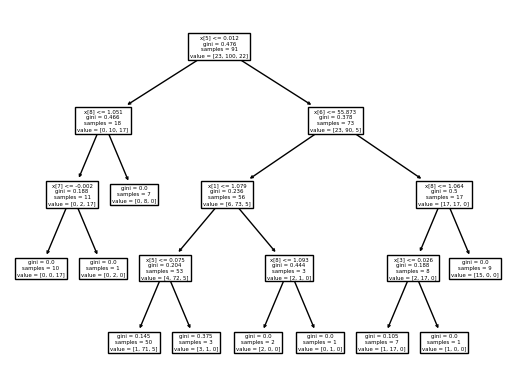

In [ ]:

print(plot_tree(rf.estimators_[0]))

[Text(0.5, 0.9, 'x[1] <= 1.081\ngini = 0.461\nsamples = 91\nvalue = [22, 102, 21]'), Text(0.4090909090909091, 0.7, 'x[2] <= 1.028\ngini = 0.389\nsamples = 84\nvalue = [11, 102, 21]'), Text(0.18181818181818182, 0.5, 'x[8] <= 1.036\ngini = 0.499\nsamples = 12\nvalue = [10, 11, 0]'), Text(0.09090909090909091, 0.3, 'gini = 0.0\nsamples = 7\nvalue = [0, 11, 0]'), Text(0.2727272727272727, 0.3, 'gini = 0.0\nsamples = 5\nvalue = [10, 0, 0]'), Text(0.6363636363636364, 0.5, 'x[6] <= 40.553\ngini = 0.317\nsamples = 72\nvalue = [1, 91, 21]'), Text(0.45454545454545453, 0.3, 'x[7] <= -0.015\ngini = 0.346\nsamples = 6\nvalue = [0, 2, 7]'), Text(0.36363636363636365, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [0, 2, 0]'), Text(0.5454545454545454, 0.1, 'gini = 0.0\nsamples = 5\nvalue = [0, 0, 7]'), Text(0.8181818181818182, 0.3, 'x[6] <= 48.596\ngini = 0.249\nsamples = 66\nvalue = [1, 89, 14]'), Text(0.7272727272727273, 0.1, 'gini = 0.414\nsamples = 25\nvalue = [0, 29, 12]'), Text(0.9090909090909091, 0.1, 'g

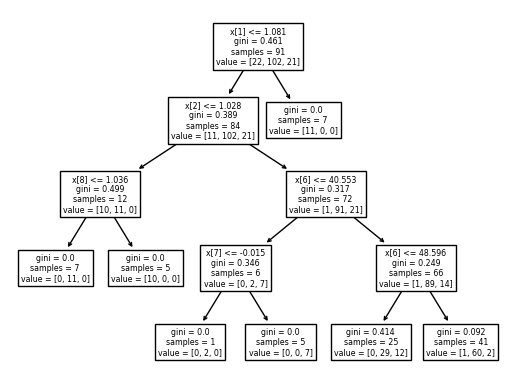

In [ ]:
print(plot_tree(rf.estimators_[1]))

[Text(0.6166666666666667, 0.9, 'x[4] <= 0.05\ngini = 0.542\nsamples = 91\nvalue = [30, 90, 25]'), Text(0.43333333333333335, 0.7, 'x[1] <= 1.079\ngini = 0.452\nsamples = 70\nvalue = [30, 74, 4]'), Text(0.26666666666666666, 0.5, 'x[7] <= 0.002\ngini = 0.319\nsamples = 56\nvalue = [12, 69, 4]'), Text(0.13333333333333333, 0.3, 'x[4] <= 0.032\ngini = 0.153\nsamples = 32\nvalue = [0, 44, 4]'), Text(0.06666666666666667, 0.1, 'gini = 0.0\nsamples = 21\nvalue = [0, 32, 0]'), Text(0.2, 0.1, 'gini = 0.375\nsamples = 11\nvalue = [0, 12, 4]'), Text(0.4, 0.3, 'x[8] <= 1.055\ngini = 0.438\nsamples = 24\nvalue = [12, 25, 0]'), Text(0.3333333333333333, 0.1, 'gini = 0.095\nsamples = 12\nvalue = [1, 19, 0]'), Text(0.4666666666666667, 0.1, 'gini = 0.457\nsamples = 12\nvalue = [11, 6, 0]'), Text(0.6, 0.5, 'x[7] <= -0.003\ngini = 0.34\nsamples = 14\nvalue = [18, 5, 0]'), Text(0.5333333333333333, 0.3, 'gini = 0.0\nsamples = 4\nvalue = [0, 5, 0]'), Text(0.6666666666666666, 0.3, 'gini = 0.0\nsamples = 10\nvalu

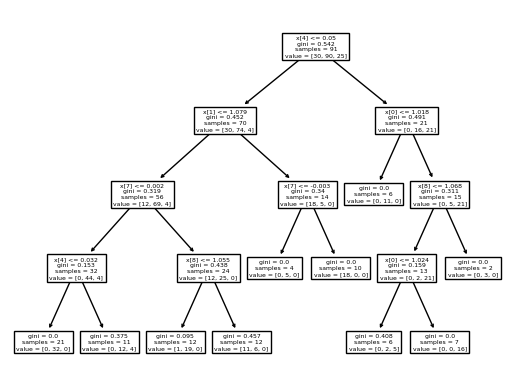

In [ ]:
print(plot_tree(rf.estimators_[2]))

## Testing model on 2022 stock data

Now that we have fit the RF Model, lets see how well the model does in predicting the buy/sell signals for the next year 2022.

We first obtain all the stock prices for MMM and SWK for the year of 2022

In [ ]:
d3 = get_historical_Data2(['MMM', 'SWK'])
print(d3.shape)
# Most Recent Data
d3

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(273, 2)


MMM         SWK
Date                              
2021-12-01  161.645126  164.332169
2021-12-02  161.200134  169.682785
2021-12-03  163.406143  174.889297
2021-12-06  167.770828  177.098740
2021-12-07  167.155426  178.722153
...                ...         ...
2022-12-23  118.570084   73.262115
2022-12-27  118.649040   73.727814
2022-12-28  116.744263   71.518250
2022-12-29  118.994469   75.214058
2022-12-30  118.352959   74.431297

[273 rows x 2 columns]

Once again, we calculate the same values needed for prediction

In [ ]:
d3['Ratio'] = d3['SWK']/d3['MMM']
d3['ratios_mavg5'] = d3['Ratio'].rolling(window=5, center=False).mean()
d3['ratios_mavg20'] = d3['Ratio'].rolling(window=20, center=False).mean()
d3['std_20'] = d3['Ratio'].rolling(window=20, center=False).std()
d3['zscore_20_5'] = (d3['ratios_mavg5']-d3['ratios_mavg20'])/d3['std_20']
d3["Upper Bollinger Bands"] = d3["ratios_mavg20"]+(2*d3['std_20'])
d3["Lower Bollinger Bands"] = d3["ratios_mavg20"]-(2*d3['std_20'])
d3['Upper Band Gap'] = d3["Upper Bollinger Bands"]-d3['Ratio']
d3['Lower Band Gap'] = d3['Ratio']-d3["Lower Bollinger Bands"]
d3['RSI'] = ta.rsi(d3['Ratio'], length=20)
d3['MACD'] = ta.macd(d3['Ratio'], fast=5, slow=15)['MACDh_5_15_9']
d3['HMA'] = ta.hma(d3['Ratio'], length=20)
d3["PairsTrading"] = d3['zscore_20_5'].apply(buysell)
d3 = d3.loc["2022-01-01":"2023-01-01"]
d3 = d3.loc[:, ['Ratio', 'ratios_mavg5', 'ratios_mavg20', 'std_20', 'Upper Band Gap', 'Lower Band Gap', 'RSI', 'MACD', 'HMA', 'PairsTrading']]
d3['PairsTrading'] = d3['PairsTrading'].map({'Sell':-1,'None':0, 'Buy':1})
d3


Ratio  ratios_mavg5  ratios_mavg20    std_20  Upper Band Gap  \
Date                                                                          
2022-01-03  1.061354      1.067032       1.077316  0.024732        0.065426   
2022-01-04  1.081875      1.070355       1.078630  0.024210        0.045175   
2022-01-05  1.081700      1.073765       1.079255  0.024115        0.045785   
2022-01-06  1.097253      1.079912       1.078725  0.023564        0.028599   
2022-01-07  1.067264      1.077889       1.076727  0.022699        0.054860   
...              ...           ...            ...       ...             ...   
2022-12-23  0.617880      0.610766       0.630763  0.016306        0.045494   
2022-12-27  0.621394      0.612085       0.629993  0.016370        0.041338   
2022-12-28  0.612606      0.610568       0.628900  0.016780        0.049854   
2022-12-29  0.632080      0.617821       0.627940  0.015961        0.027781   
2022-12-30  0.628893      0.622571       0.626586  0.014544        0.026781   

            Lower Band Gap        RSI      MACD       HMA  PairsTrading  
Date                                                                     
2022-01-03        0.033502  52.494945  0.005457  1.053796             0  
2022-01-04        0.051666  58.960125  0.007341  1.058650             0  
2022-01-05        0.050675  58.888154  0.007564  1.064422             0  
2022-01-06        0.065655  63.100253  0.009543  1.071837             0  
2022-01-07        0.035934  52.237500  0.004442  1.076613             0  
...                    ...        ...       ...       ...           ...  
2022-12-23        0.019729  45.618533 -0.003697  0.615336             1  
2022-12-27        0.024140  46.549994 -0.000828  0.612283             1  
2022-12-28        0.017266  44.541531 -0.000655  0.609952             1  
2022-12-29        0.036062  49.612735  0.002956  0.610346             0  
2022-12-30        0.031394  48.843174  0.003948  0.612310             0  

[251 rows x 10 columns]

We now create a dataframe with ratio values and pairstrading values so that we may compare the predicted buy/sell with the Rolling Z-Score buy/sell

In [ ]:
result = pd.DataFrame(d3['PairsTrading'])
test = pd.DataFrame(d3.drop('PairsTrading', axis=1))
compare = d3.loc[:,['Ratio', 'PairsTrading']]
compare

Ratio  PairsTrading
Date                              
2022-01-03  1.061354             0
2022-01-04  1.081875             0
2022-01-05  1.081700             0
2022-01-06  1.097253             0
2022-01-07  1.067264             0
...              ...           ...
2022-12-23  0.617880             1
2022-12-27  0.621394             1
2022-12-28  0.612606             1
2022-12-29  0.632080             0
2022-12-30  0.628893             0

[251 rows x 2 columns]

In [ ]:
original = compare.copy()
original.loc[original['PairsTrading'] != 1, 'Buy'] = np.nan
original.loc[original['PairsTrading'] == 1, 'Buy'] = 1
mask = original['Buy'] == 1
original.loc[mask, 'Buy'] = original.loc[mask, 'Ratio']

original.loc[original['PairsTrading'] != -1, 'Sell'] = np.nan
original.loc[original['PairsTrading'] == -1, 'Sell'] = -1
mask = original['Sell'] == -1
original.loc[mask, 'Sell'] = original.loc[mask, 'Ratio']
original = original.loc[:, ['Ratio', 'Buy', 'Sell']]
original

Ratio       Buy  Sell
Date                                
2022-01-03  1.061354       NaN   NaN
2022-01-04  1.081875       NaN   NaN
2022-01-05  1.081700       NaN   NaN
2022-01-06  1.097253       NaN   NaN
2022-01-07  1.067264       NaN   NaN
...              ...       ...   ...
2022-12-23  0.617880  0.617880   NaN
2022-12-27  0.621394  0.621394   NaN
2022-12-28  0.612606  0.612606   NaN
2022-12-29  0.632080       NaN   NaN
2022-12-30  0.628893       NaN   NaN

[251 rows x 3 columns]

We now obtain the predicted values for 2022 in the 'prediction' dataframe

In [ ]:
result1 = pd.DataFrame(d3['Ratio'])
result2 = result1.reset_index()
prediction = pd.DataFrame(rf.predict(test))
prediction

0
0    0
1    0
2    0
3    0
4    0
..  ..
246  0
247  0
248  0
249  0
250  0

[251 rows x 1 columns]

In [ ]:
def replace_one_with_buy(x):
    if x == 1:
        return 'buy'
    elif x==0:
      return 'None'
    elif x== -1:
      return 'Sell'

In [ ]:
prediction2 = prediction.copy()
prediction2 = prediction2.rename(columns={0: 'PairsTrading'})
prediction2 = prediction2.applymap(replace_one_with_buy)


p68 = get_historical_Data2(["MMM", "SWK"])
p68 = p68.loc["2022-01-01":"2023-01-01"]
p69 = p68.reset_index()
rf_predictions = pd.concat([p69, prediction2], axis=1)
rf_predictions = rf_predictions.set_index('Date')

rf_predictions

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


MMM         SWK PairsTrading
Date                                           
2022-01-03  168.282120  178.606888         None
2022-01-04  170.639587  184.610703         None
2022-01-05  169.938980  183.823013         None
2022-01-06  168.528259  184.918106         None
2022-01-07  170.374512  181.834534         None
...                ...         ...          ...
2022-12-23  118.570084   73.262115         None
2022-12-27  118.649040   73.727814         None
2022-12-28  116.744263   71.518250         None
2022-12-29  118.994469   75.214058         None
2022-12-30  118.352959   74.431297         None

[251 rows x 3 columns]

In [ ]:
pred2 = pd.concat([result2, prediction], axis=1)
pred2 = pred2.set_index('Date')
pred2 = pred2.rename(columns={0: 'PairsTrading'})

pred3 = pred2.copy()
pred3.loc[pred3['PairsTrading'] != 1, 'Buy'] = np.nan
pred3.loc[pred3['PairsTrading'] == 1, 'Buy'] = 1
mask = pred3['Buy'] == 1
pred3.loc[mask, 'Buy'] = pred3.loc[mask, 'Ratio']

pred3.loc[pred3['PairsTrading'] != -1, 'Sell'] = np.nan
pred3.loc[pred3['PairsTrading'] == -1, 'Sell'] = -1
mask = pred3['Sell'] == -1
pred3.loc[mask, 'Sell'] = pred3.loc[mask, 'Ratio']
pred3 = pred3.loc[:, ['Ratio', 'Buy', 'Sell']]
pred3

Ratio  Buy  Sell
Date                           
2022-01-03  1.061354  NaN   NaN
2022-01-04  1.081875  NaN   NaN
2022-01-05  1.081700  NaN   NaN
2022-01-06  1.097253  NaN   NaN
2022-01-07  1.067264  NaN   NaN
...              ...  ...   ...
2022-12-23  0.617880  NaN   NaN
2022-12-27  0.621394  NaN   NaN
2022-12-28  0.612606  NaN   NaN
2022-12-29  0.632080  NaN   NaN
2022-12-30  0.628893  NaN   NaN

[251 rows x 3 columns]

As we can see, prediction accuracy fell to 0.617. This can be accounted for due to the lack of integration and stationarity between MMM and SWK in 2022 as compared to 2021

In [ ]:
accuracy = accuracy_score(result, prediction)
print("Accuracy:", accuracy)

Accuracy: 0.6852589641434262


Graph of buy/sell signals using rolling z-score

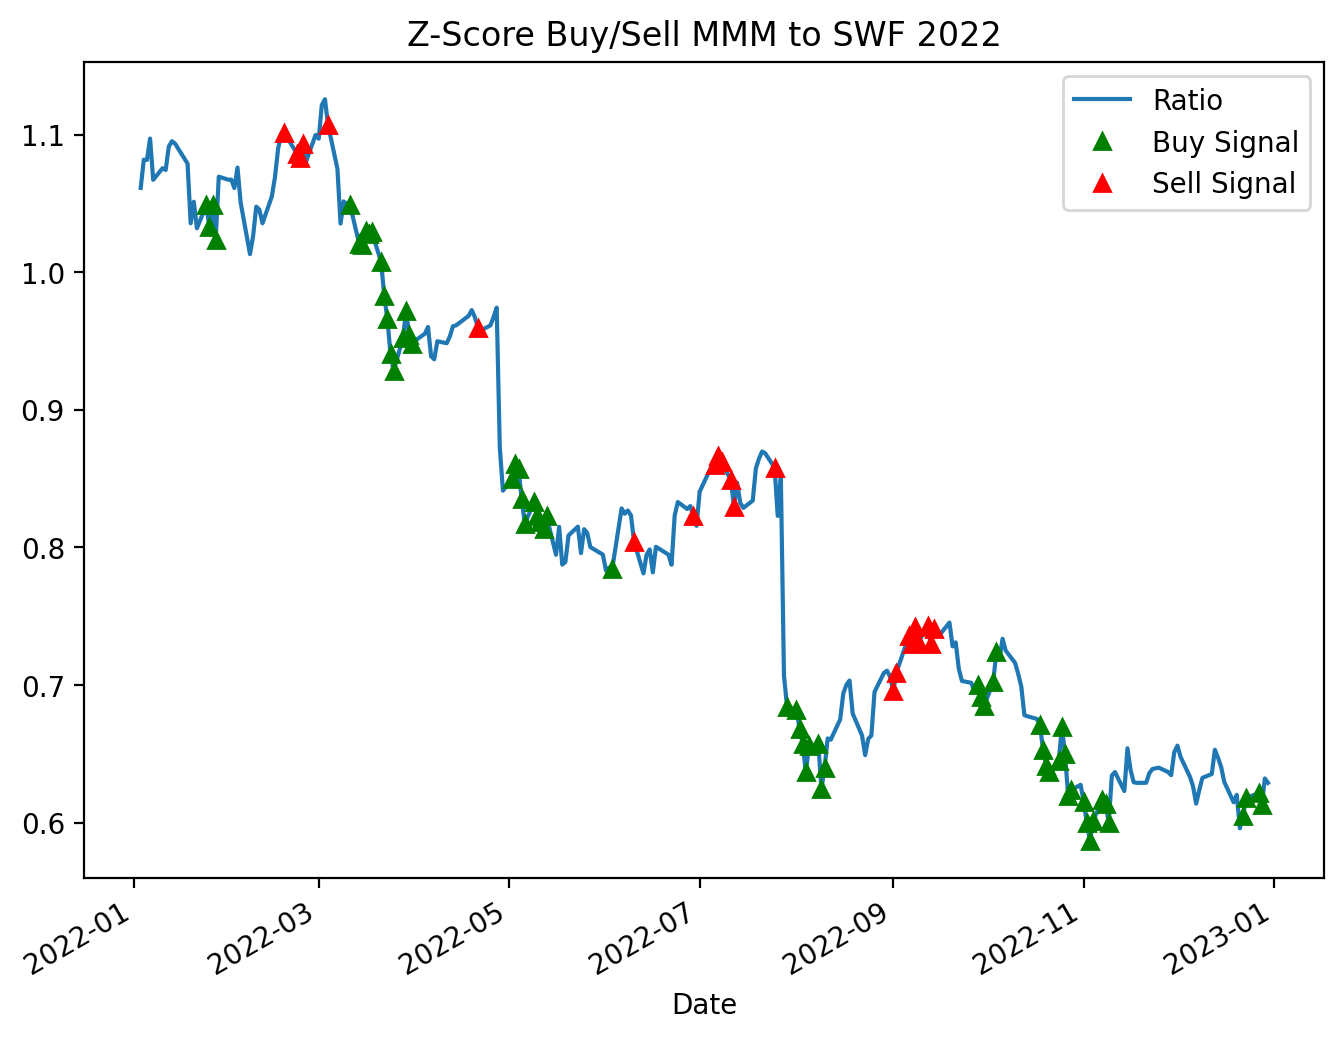

In [ ]:
figure(figsize=(8, 6), dpi=200)
original['Ratio'].plot()
original['Buy'].plot(color='g', linestyle='None', marker='^')
original['Sell'].plot(color='r', linestyle='None', marker='^')
# x1, x2, y1, y2 = plt.axis()
# plt.axis((x1, x2, ratio.min(), ratio.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.title('Z-Score Buy/Sell MMM to SWF 2022')
plt.show()

Predicted buy/sell signals using Random Forest Model

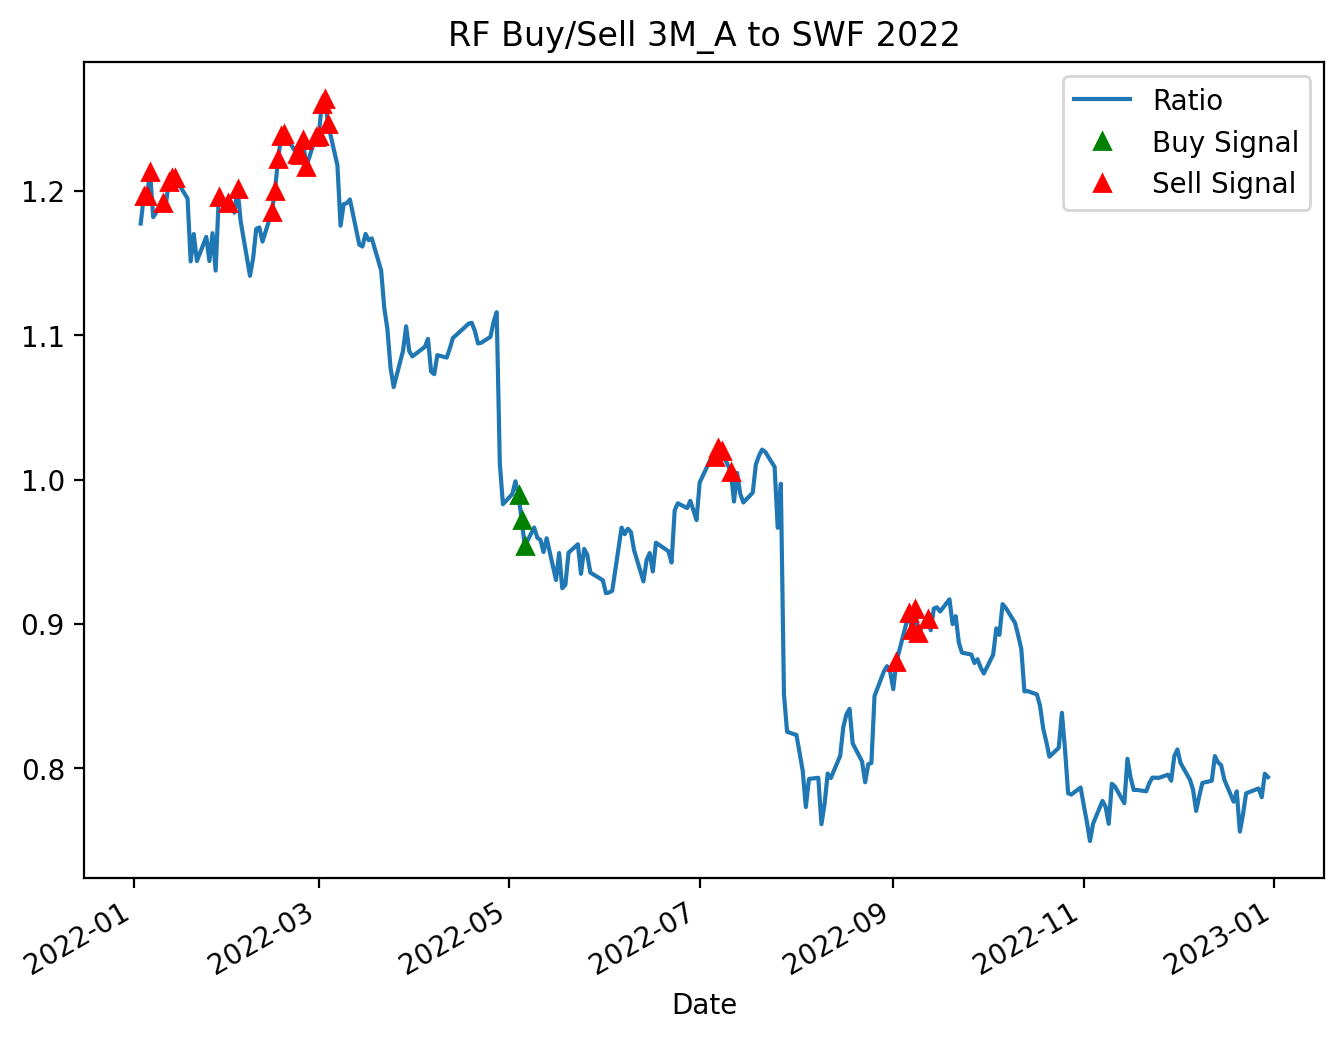

In [ ]:
figure(figsize=(8, 6), dpi=200)
pred3['Ratio'].plot()
pred3['Buy'].plot(color='g', linestyle='None', marker='^')
pred3['Sell'].plot(color='r', linestyle='None', marker='^')
# x1, x2, y1, y2 = plt.axis()
# plt.axis((x1, x2, ratio.min(), ratio.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.title('RF Buy/Sell 3M_A to SWF 2022')
plt.show()

## Profit/ Loss Calculation of Random Forest

In [ ]:
trade(rf_predictions['SWK'], rf_predictions['MMM'],rf_predictions['PairsTrading'],10)

391.47262164592775

With similar trading signals and profit of $391.47 from the Random Forest model, we see that the model performs better compared to the initial z-score method, indicating potential further exploration on its development.

# Conducting Pairs Trading Strategy using Artificial Neural Network

Next, let's use an ANN to predict the trade signals based on a bunch of technical indicators.

In [63]:
ann_data = df.copy(deep=True)
ann_data

SWK         MMM     Ratio  ratios_mavg5  ratios_mavg20  \
Date                                                                        
2021-01-04  160.181396  157.718201  1.015618      1.043029       1.052312   
2021-01-05  160.919159  157.452087  1.022020      1.038243       1.049369   
2021-01-06  166.698364  159.847183  1.042861      1.037799       1.047461   
2021-01-07  167.814499  155.745255  1.077493      1.042191       1.048377   
2021-01-08  167.161835  152.900482  1.093272      1.050253       1.050622   
...                ...         ...       ...           ...            ...   
2021-12-27  176.848969  167.297440  1.057093      1.052595       1.072455   
2021-12-28  179.164032  168.187439  1.065264      1.056498       1.072935   
2021-12-29  179.836472  168.916458  1.064647      1.059091       1.074029   
2021-12-30  179.375381  168.187439  1.066521      1.062010       1.076524   
2021-12-31  181.190918  168.177963  1.077376      1.066180       1.077762   

              std_20  zscore_20_5 PairsTrading  
Date                                            
2021-01-04  0.016778    -0.553270         None  
2021-01-05  0.016665    -0.667625         None  
2021-01-06  0.014948    -0.646392         None  
2021-01-07  0.016211    -0.381609         None  
2021-01-08  0.019068    -0.019373         None  
...              ...          ...          ...  
2021-12-27  0.029450    -0.674342         None  
2021-12-28  0.029239    -0.562169         None  
2021-12-29  0.028449    -0.525101         None  
2021-12-30  0.025146    -0.577176         None  
2021-12-31  0.024509    -0.472550         None  

[252 rows x 8 columns]

In [64]:
ann_data["Upper Bollinger Bands"] = ann_data["ratios_mavg20"]+(2*ann_data['std_20'])
ann_data["Lower Bollinger Bands"] = ann_data["ratios_mavg20"]-(2*ann_data['std_20'])
ann_data['Upper Band Gap'] = ann_data["Upper Bollinger Bands"]-ann_data['Ratio']
ann_data['Lower Band Gap'] = ann_data['Ratio']-ann_data["Lower Bollinger Bands"]
ann_data['RSI'] = ta.rsi(ann_data['Ratio'], length=20)
ann_data['MACD'] = ta.macd(ann_data['Ratio'], fast=5, slow=15)['MACDh_5_15_9']
ann_data['HMA'] = ta.hma(ann_data['Ratio'], length=20)

We clean the input ANN dataset to ensure no errors later on.

In [65]:
ann_data = ann_data.dropna()
ann_data

SWK         MMM     Ratio  ratios_mavg5  ratios_mavg20  \
Date                                                                        
2021-02-04  166.130829  162.517578  1.022233      1.027135       1.053162   
2021-02-05  167.076691  164.270309  1.017084      1.026952       1.050142   
2021-02-08  166.168655  165.876205  1.001763      1.021654       1.045566   
2021-02-09  166.074081  166.041382  1.000197      1.013074       1.040561   
2021-02-10  167.700989  166.169861  1.009214      1.010098       1.036403   
...                ...         ...       ...           ...            ...   
2021-12-27  176.848969  167.297440  1.057093      1.052595       1.072455   
2021-12-28  179.164032  168.187439  1.065264      1.056498       1.072935   
2021-12-29  179.836472  168.916458  1.064647      1.059091       1.074029   
2021-12-30  179.375381  168.187439  1.066521      1.062010       1.076524   
2021-12-31  181.190918  168.177963  1.077376      1.066180       1.077762   

              std_20  zscore_20_5 PairsTrading  Upper Bollinger Bands  \
Date                                                                    
2021-02-04  0.035177    -0.739912         None               1.123516   
2021-02-05  0.035569    -0.651970         None               1.121280   
2021-02-08  0.035615    -0.671421         None               1.116796   
2021-02-09  0.034535    -0.795916         None               1.109632   
2021-02-10  0.032937    -0.798627         None               1.102277   
...              ...          ...          ...                    ...   
2021-12-27  0.029450    -0.674342         None               1.131354   
2021-12-28  0.029239    -0.562169         None               1.131412   
2021-12-29  0.028449    -0.525101         None               1.130927   
2021-12-30  0.025146    -0.577176         None               1.126816   
2021-12-31  0.024509    -0.472550         None               1.126779   

            Lower Bollinger Bands  Upper Band Gap  Lower Band Gap        RSI  \
Date                                                                           
2021-02-04               0.982809        0.101283        0.039424  46.901760   
2021-02-05               0.979004        0.104196        0.038080  45.792292   
2021-02-08               0.974337        0.115032        0.027426  42.633587   
2021-02-09               0.971490        0.109435        0.028707  42.319481   
2021-02-10               0.970528        0.093063        0.038686  44.784999   
...                           ...             ...             ...        ...   
2021-12-27               1.013555        0.074261        0.043538  48.385242   
2021-12-28               1.014458        0.066148        0.050806  50.169850   
2021-12-29               1.017131        0.066280        0.047516  50.032431   
2021-12-30               1.026232        0.060295        0.040288  50.466297   
2021-12-31               1.028745        0.049403        0.048632  52.957908   

                MACD       HMA  
Date                            
2021-02-04  0.004274  1.007813  
2021-02-05  0.003055  1.007717  
2021-02-08  0.000048  1.006503  
2021-02-09 -0.001151  1.005160  
2021-02-10  0.000408  1.004973  
...              ...       ...  
2021-12-27 -0.007639  1.060999  
2021-12-28 -0.004058  1.054428  
2021-12-29 -0.001891  1.050573  
2021-12-30 -0.000205  1.049233  
2021-12-31  0.002557  1.051244  

[230 rows x 15 columns]

We split the training data into before Aug 2021 and test data to after Aug 2021 till the end of 2021.

In [66]:
X_train = ann_data.loc[:"2021-08-01"].drop(["PairsTrading","zscore_20_5","Upper Bollinger Bands","Lower Bollinger Bands"], axis=1)
y_train_inter = ann_data.loc[:"2021-08-01"]["PairsTrading"].to_numpy()
X_test = ann_data.loc["2021-08-01":].drop(["PairsTrading","zscore_20_5", "Upper Bollinger Bands","Lower Bollinger Bands"], axis=1).to_numpy()
y_test_inter = ann_data.loc["2021-08-01":]["PairsTrading"].to_numpy()

In [67]:
X_train

SWK         MMM     Ratio  ratios_mavg5  ratios_mavg20  \
Date                                                                        
2021-02-04  166.130829  162.517578  1.022233      1.027135       1.053162   
2021-02-05  167.076691  164.270309  1.017084      1.026952       1.050142   
2021-02-08  166.168655  165.876205  1.001763      1.021654       1.045566   
2021-02-09  166.074081  166.041382  1.000197      1.013074       1.040561   
2021-02-10  167.700989  166.169861  1.009214      1.010098       1.036403   
...                ...         ...       ...           ...            ...   
2021-07-26  196.212265  187.962570  1.043890      1.040203       1.052768   
2021-07-27  192.049484  186.844147  1.027859      1.038190       1.050890   
2021-07-28  186.172073  184.802979  1.007408      1.031709       1.047979   
2021-07-29  188.410629  184.700485  1.020087      1.028031       1.046244   
2021-07-30  187.705734  184.486115  1.017452      1.023339       1.044128   

              std_20  Upper Band Gap  Lower Band Gap        RSI      MACD  \
Date                                                                        
2021-02-04  0.035177        0.101283        0.039424  46.901760  0.004274   
2021-02-05  0.035569        0.104196        0.038080  45.792292  0.003055   
2021-02-08  0.035615        0.115032        0.027426  42.633587  0.000048   
2021-02-09  0.034535        0.109435        0.028707  42.319481 -0.001151   
2021-02-10  0.032937        0.093063        0.038686  44.784999  0.000408   
...              ...             ...             ...        ...       ...   
2021-07-26  0.012503        0.033884        0.016128  46.490286  0.000181   
2021-07-27  0.013298        0.049627        0.003565  40.752965 -0.001686   
2021-07-28  0.015999        0.072569       -0.008571  34.959442 -0.005594   
2021-07-29  0.017068        0.060294        0.007980  40.481302 -0.004430   
2021-07-30  0.017905        0.062487        0.009135  39.743020 -0.003551   

                 HMA  
Date                  
2021-02-04  1.007813  
2021-02-05  1.007717  
2021-02-08  1.006503  
2021-02-09  1.005160  
2021-02-10  1.004973  
...              ...  
2021-07-26  1.033758  
2021-07-27  1.032543  
2021-07-28  1.028891  
2021-07-29  1.025023  
2021-07-30  1.021168  

[123 rows x 11 columns]

We encode the values for our ANN.

In [68]:
encoder = LabelEncoder()
encoder.fit(ann_data["PairsTrading"].to_numpy())
y_train = encoder.transform(y_train_inter)
y_test  = encoder.transform(y_test_inter)

In [69]:
print(encoder.classes_)


['Buy' 'None' 'Sell']


We utilize gridSearchCV to optimize the hyperparameters for our ANN. 

In [70]:
def create_model():
    model = Sequential()
    model.add(Dense(32, activation="relu", input_dim=X_train.shape[1]))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(3, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

# Create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# Define hyperparameters to tune
param_grid = {
    "batch_size": [32, 128, 256],
    "epochs": [50, 150, 250],
    # "optimizer": ["adam", "SGD"]
}

# Create grid search object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring='accuracy')

# Fit grid search
grid_result = grid.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters:", grid_result.best_params_)
print("Best score:", grid_result.best_score_)


<ipython-input-70-7eb90d07079b>:12: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


Best parameters: {'batch_size': 128, 'epochs': 50}
Best score: 0.6585365853658537


We're ready to run the model! Let's see the test loss and accuracy.

In [99]:
# Define model architecture
stock_model = Sequential()
stock_model.add(Dense(32, activation="relu", input_dim=X_train.shape[1]))
stock_model.add(Dense(64, activation="relu"))
stock_model.add(Dense(128, activation="relu"))
stock_model.add(Dense(256, activation="relu"))
stock_model.add(Dense(3, activation="softmax"))

# # Compile model
stock_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train model
stock_model.fit(X_train, y_train, epochs=150, batch_size=128, validation_data=(X_test, y_test))

# # Evaluate model
loss, accuracy = stock_model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

# # Make predictions
predictions = stock_model.predict(X_test)

Epoch 1/150
1/1 [==============================] - 1s 1s/step - loss: 18.4984 - accuracy: 0.1789 - val_loss: 4.0949 - val_accuracy: 0.6636
Epoch 2/150
1/1 [==============================] - 0s 43ms/step - loss: 3.7722 - accuracy: 0.6585 - val_loss: 3.7948 - val_accuracy: 0.6636
Epoch 3/150
1/1 [==============================] - 0s 42ms/step - loss: 4.1170 - accuracy: 0.6585 - val_loss: 2.1342 - val_accuracy: 0.6822
Epoch 4/150
1/1 [==============================] - 0s 40ms/step - loss: 2.7830 - accuracy: 0.6504 - val_loss: 4.3961 - val_accuracy: 0.2056
Epoch 5/150
1/1 [==============================] - 0s 41ms/step - loss: 5.2786 - accuracy: 0.1626 - val_loss: 2.6107 - val_accuracy: 0.6636
Epoch 6/150
1/1 [==============================] - 0s 42ms/step - loss: 3.3200 - accuracy: 0.6585 - val_loss: 3.2304 - val_accuracy: 0.6636
Epoch 7/150
1/1 [==============================] - 0s 46ms/step - loss: 3.8065 - accuracy: 0.6585 - val_loss: 2.8889 - val_accuracy: 0.6636
Epoch 8/150
1/1 [====

These results look good. Let's save the weights in case we want to rerun the same model.

In [122]:
stock_model.save_weights('./checkpoints/my_checkpoint')

In [36]:
from keras_visualizer import visualizer
visualizer(stock_model, file_format='png', view=True)

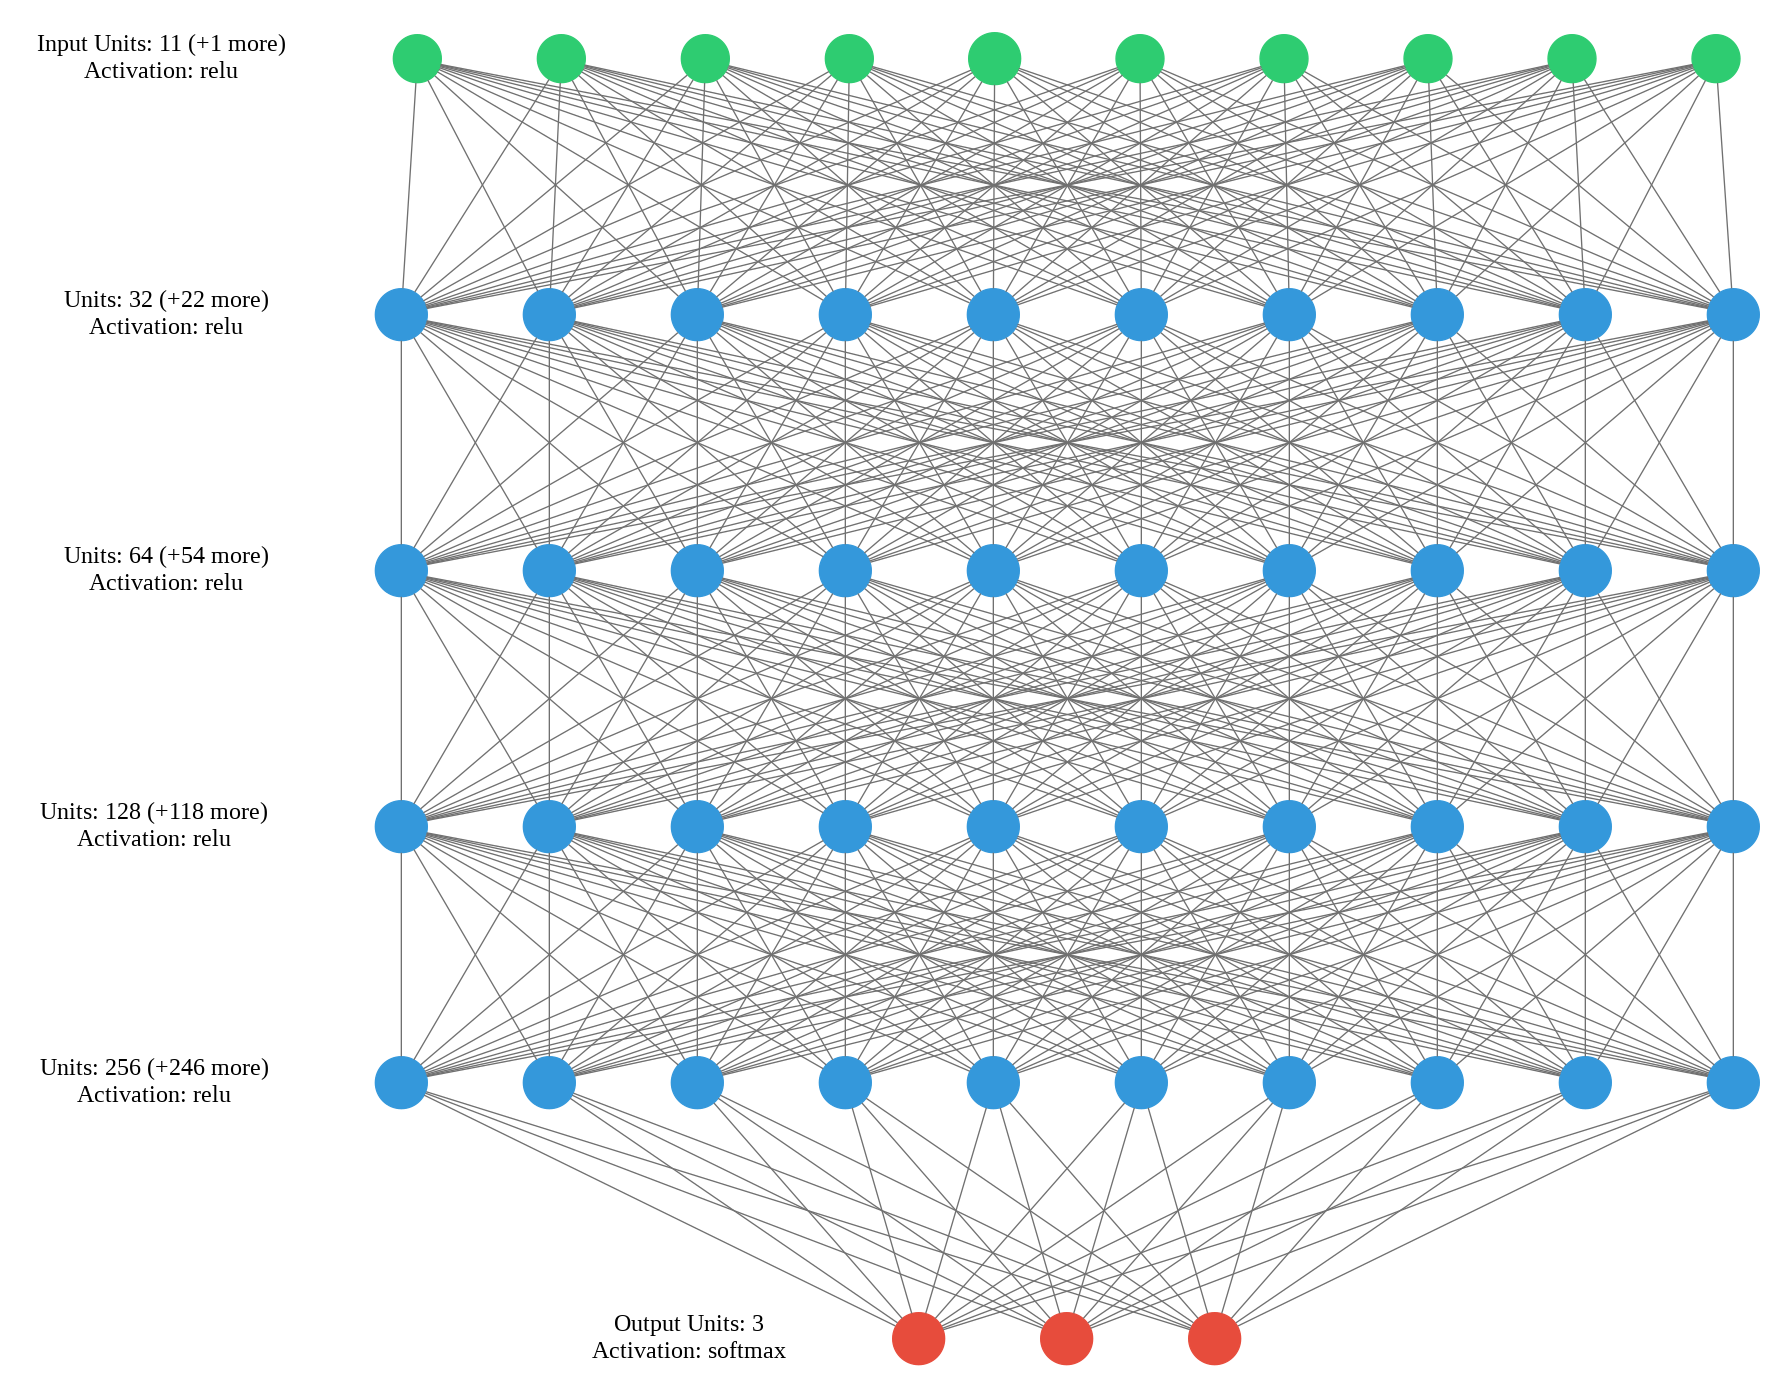

### Testing against 22/23 stock data

Now, let's test the data against our 2023 stock data.

In [112]:
d_test = get_historical_Data2(['SWK', 'MMM'])
d2_year = d_test.loc["2022-01-01":]

df2 = d2_year.copy(deep=True)
df2['Ratio'] = df2['SWK']/df2['MMM']
df2['ratios_mavg5'] = df2['Ratio'].rolling(window=5, center=False).mean()
df2['ratios_mavg20'] = df2['Ratio'].rolling(window=20, center=False).mean()
df2['std_20'] = df2['Ratio'].rolling(window=20, center=False).std()
df2["Upper Bollinger Bands"] = df2["ratios_mavg20"]+(2*df2['std_20'])
df2["Lower Bollinger Bands"] = df2["ratios_mavg20"]-(2*df2['std_20'])
df2['Upper Band Gap'] = df2["Upper Bollinger Bands"]-df2['Ratio']
df2['Lower Band Gap'] = df2['Ratio']-df2["Lower Bollinger Bands"]
df2['RSI'] = ta.rsi(df2['Ratio'], length=20)
df2['MACD'] = ta.macd(df2['Ratio'], fast=5, slow=15)['MACDh_5_15_9']
df2['HMA'] = ta.hma(df2['Ratio'], length=20)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [113]:
df2 = df2.dropna()
df2 = df2.drop(["Upper Bollinger Bands","Lower Bollinger Bands"], axis=1)
df2

SWK         MMM     Ratio  ratios_mavg5  ratios_mavg20  \
Date                                                                        
2022-02-03  167.492599  155.642487  1.076137      1.068326       1.064434   
2022-02-04  159.913330  152.177216  1.050836      1.064587       1.062113   
2022-02-07  154.610764  152.593826  1.013218      1.053762       1.059411   
2022-02-08  157.828812  153.767838  1.026410      1.045567       1.056947   
2022-02-09  162.324478  154.932388  1.047712      1.042862       1.055613   
...                ...         ...       ...           ...            ...   
2022-12-23   73.262115  118.570084  0.617880      0.610766       0.630763   
2022-12-27   73.727814  118.649040  0.621394      0.612085       0.629993   
2022-12-28   71.518250  116.744263  0.612606      0.610568       0.628900   
2022-12-29   75.214058  118.994469  0.632080      0.617821       0.627940   
2022-12-30   74.431297  118.352959  0.628893      0.622571       0.626586   

              std_20  Upper Band Gap  Lower Band Gap        RSI      MACD  \
Date                                                                        
2022-02-03  0.022304        0.032905        0.056311  53.434472  0.012667   
2022-02-04  0.021091        0.053459        0.030905  47.359988  0.007560   
2022-02-07  0.023698        0.093589        0.001202  40.206291 -0.001669   
2022-02-08  0.024466        0.079470        0.018394  43.364190 -0.003264   
2022-02-09  0.024190        0.056281        0.040479  48.029510  0.000270   
...              ...             ...             ...        ...       ...   
2022-12-23  0.016306        0.045494        0.019729  45.618518 -0.003697   
2022-12-27  0.016370        0.041338        0.024140  46.549982 -0.000828   
2022-12-28  0.016780        0.049854        0.017266  44.541515 -0.000655   
2022-12-29  0.015961        0.027781        0.036062  49.612730  0.002956   
2022-12-30  0.014544        0.026781        0.031394  48.843168  0.003948   

                 HMA  
Date                  
2022-02-03  1.052738  
2022-02-04  1.057187  
2022-02-07  1.055394  
2022-02-08  1.050885  
2022-02-09  1.047062  
...              ...  
2022-12-23  0.615336  
2022-12-27  0.612283  
2022-12-28  0.609952  
2022-12-29  0.610346  
2022-12-30  0.612310  

[229 rows x 11 columns]

In [114]:
X_22 = df2.to_numpy()
predictions_2022 = stock_model.predict(X_22)
predicted_labels = np.argmax(predictions_2022, axis=1)

df2['PairsTrading_ratioPrediction'] = predicted_labels

8/8 [==============================] - 0s 5ms/step


Text(0.5, 1.0, 'Price Ratio between SWK and MMM 2022')

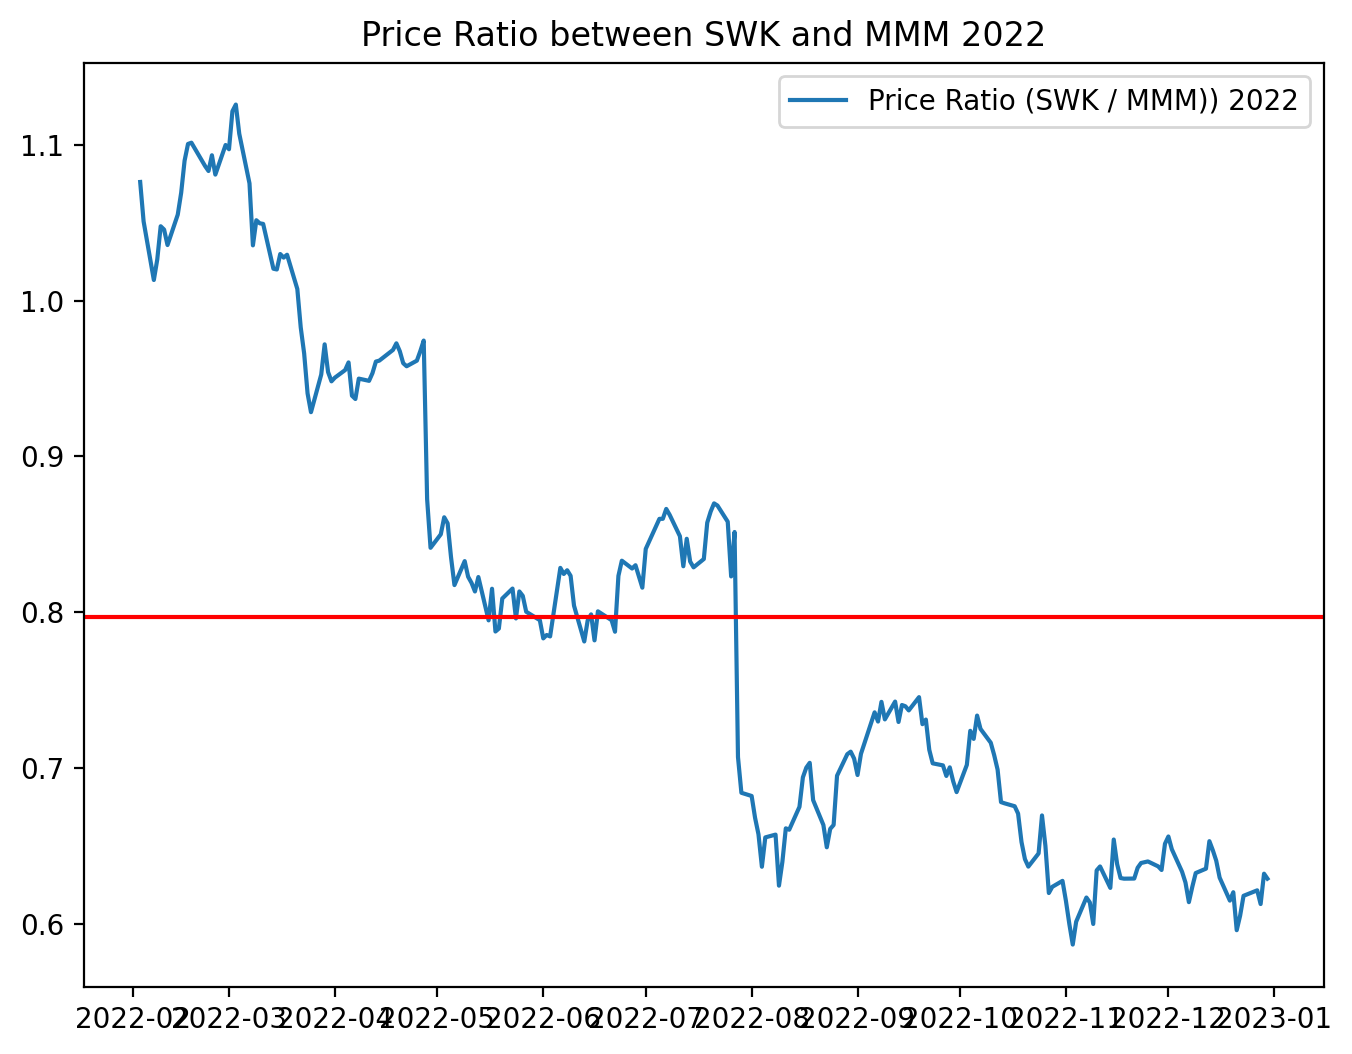

In [115]:
figure(figsize=(8, 6), dpi=200)
plt.plot(df2['Ratio'], label = 'Price Ratio (SWK / MMM)) 2022')
plt.axhline(df2['Ratio'].mean(), color='red')
plt.legend()
plt.title("Price Ratio between SWK and MMM 2022")

In [116]:
ratio_df = pd.DataFrame(df2['Ratio'])
buy = df2[df2['PairsTrading_ratioPrediction']==0]
buy = pd.DataFrame(buy['Ratio'])

sell = df2[df2['PairsTrading_ratioPrediction']==2]
sell = pd.DataFrame(sell['Ratio'])

merged_df = pd.merge(ratio_df, buy, on='Date', how='outer')
merged_df2 = pd.merge(merged_df, sell, on='Date', how='outer')

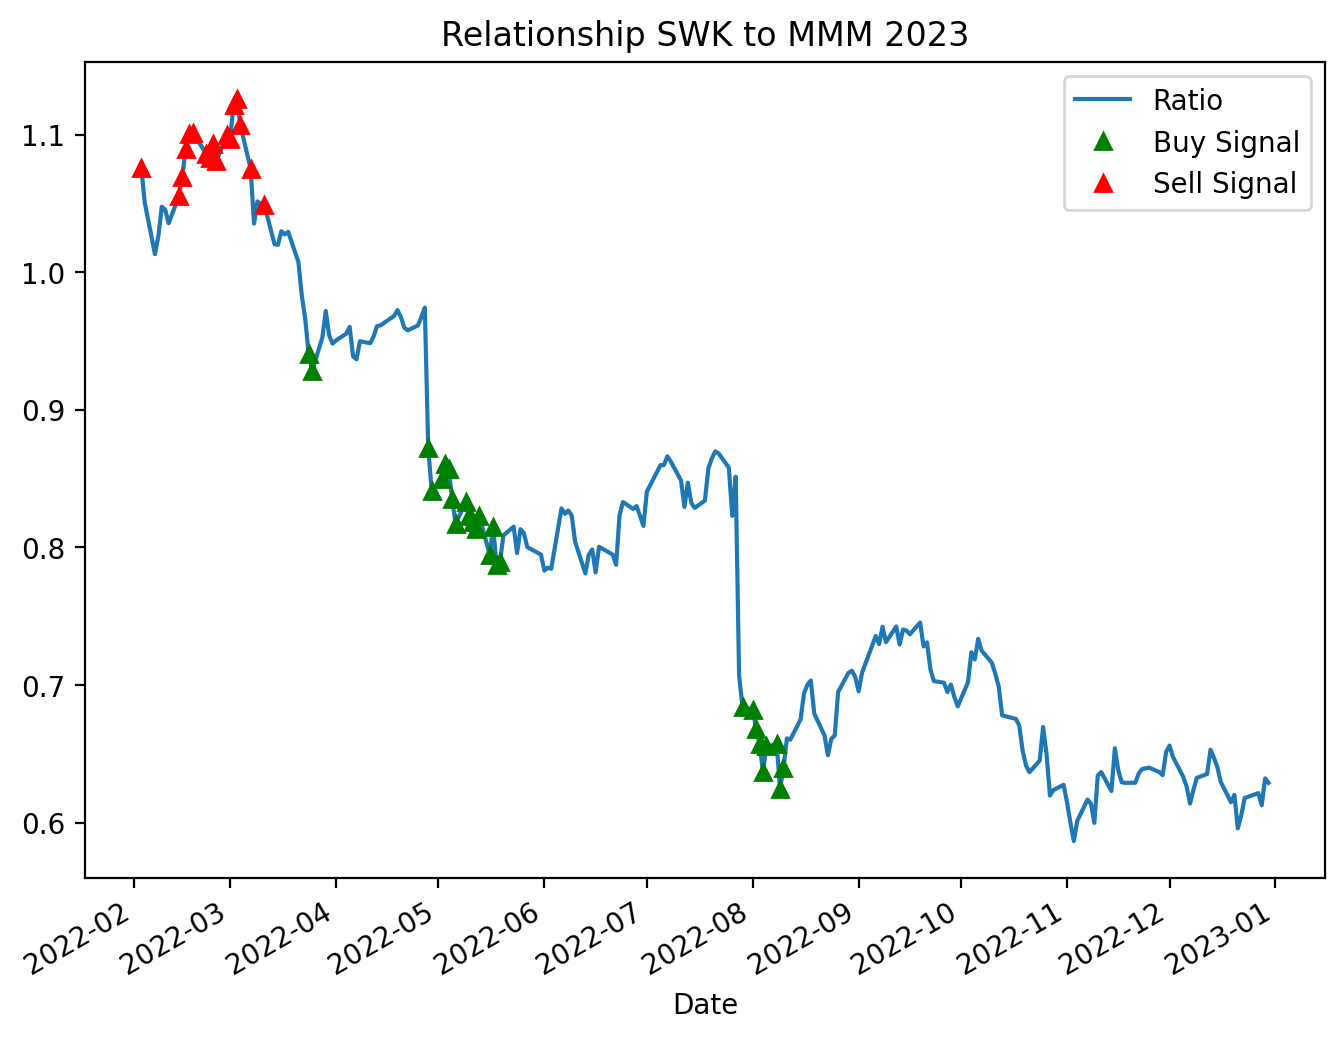

In [117]:
figure(figsize=(8, 6), dpi=200)
merged_df2['Ratio_x'].plot()
merged_df2['Ratio_y'].plot(color='g', linestyle='None', marker='^')
merged_df2['Ratio'].plot(color='r', linestyle='None', marker='^')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.title('Relationship SWK to MMM 2023')
plt.show()

As we can see from the graph, the trade signals show a lot more promise as compared to that of RF and the decision tree. With greater tuning and training of the model, We are likely to obtain an even more accurate ANN than this.

### Profit/ Loss Calculation using ANN

In [118]:
df2['PairsTrading_ratioPrediction'] = df2['PairsTrading_ratioPrediction'].map({0:'Buy', 1:'None', 2:'Sell'})


In [119]:
df2

SWK         MMM     Ratio  ratios_mavg5  ratios_mavg20  \
Date                                                                        
2022-02-03  167.492599  155.642487  1.076137      1.068326       1.064434   
2022-02-04  159.913330  152.177216  1.050836      1.064587       1.062113   
2022-02-07  154.610764  152.593826  1.013218      1.053762       1.059411   
2022-02-08  157.828812  153.767838  1.026410      1.045567       1.056947   
2022-02-09  162.324478  154.932388  1.047712      1.042862       1.055613   
...                ...         ...       ...           ...            ...   
2022-12-23   73.262115  118.570084  0.617880      0.610766       0.630763   
2022-12-27   73.727814  118.649040  0.621394      0.612085       0.629993   
2022-12-28   71.518250  116.744263  0.612606      0.610568       0.628900   
2022-12-29   75.214058  118.994469  0.632080      0.617821       0.627940   
2022-12-30   74.431297  118.352959  0.628893      0.622571       0.626586   

              std_20  Upper Band Gap  Lower Band Gap        RSI      MACD  \
Date                                                                        
2022-02-03  0.022304        0.032905        0.056311  53.434472  0.012667   
2022-02-04  0.021091        0.053459        0.030905  47.359988  0.007560   
2022-02-07  0.023698        0.093589        0.001202  40.206291 -0.001669   
2022-02-08  0.024466        0.079470        0.018394  43.364190 -0.003264   
2022-02-09  0.024190        0.056281        0.040479  48.029510  0.000270   
...              ...             ...             ...        ...       ...   
2022-12-23  0.016306        0.045494        0.019729  45.618518 -0.003697   
2022-12-27  0.016370        0.041338        0.024140  46.549982 -0.000828   
2022-12-28  0.016780        0.049854        0.017266  44.541515 -0.000655   
2022-12-29  0.015961        0.027781        0.036062  49.612730  0.002956   
2022-12-30  0.014544        0.026781        0.031394  48.843168  0.003948   

                 HMA PairsTrading_ratioPrediction  
Date                                               
2022-02-03  1.052738                         Sell  
2022-02-04  1.057187                         None  
2022-02-07  1.055394                         None  
2022-02-08  1.050885                         None  
2022-02-09  1.047062                         None  
...              ...                          ...  
2022-12-23  0.615336                         None  
2022-12-27  0.612283                         None  
2022-12-28  0.609952                         None  
2022-12-29  0.610346                         None  
2022-12-30  0.612310                         None  

[229 rows x 12 columns]

In [120]:
trade(df2['SWK'],df2['MMM'],df2['PairsTrading_ratioPrediction'], 10)

371.2141549877173

The profit generated by the ANN is higher than that of the initial Z-score method as well. While the profitability is lower than that of RF, its classification accuracy is comparatively higher.

# Conclusion

The profitability of the various methods is as shown.

| Method        | Profit  |
|---------------|---------|
| Z-score       | 293.87 |
| Decision Tree | 75.23  |
| Random Forest | 391.47 |
| ANN           | 371.21 |

From this exercise, we can conclude that while Pairs Trading implementation using Z-score performs well, this does not mean that other techniques cannot replace it. In particular, random forest and ANN show potential in its applicability and profitability.

With further development, through tuning and consideration of other indicators, new machine learning methods hold potential for replacing the traditional way of doing pairs trading.